In [ ]:
!pip install transformers==4.28.0
!pip install datasets
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.7/214.7 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl si

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(
    project='alm_model_run30_gpt2_frozen_whisper',
)

wandb: Currently logged in as: devansh20053 (devansh2002). Use `wandb login --relogin` to force relogin


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from transformers import AutoConfig, WhisperFeatureExtractor, WhisperModel, GPT2LMHeadModel, GPT2Tokenizer

In [ ]:
#Dataset downloading
import torchaudio
root = './'
train_dataset = torchaudio.datasets.LIBRISPEECH(root, url='train-clean-100', download=True)

100%|██████████| 5.95G/5.95G [00:38<00:00, 166MB/s]


In [ ]:
print(type(train_dataset))

<class 'torchaudio.datasets.librispeech.LIBRISPEECH'>


In [ ]:
#80% training 10% validation and 10% testing
from torch.utils.data import random_split
lengths = [int(len(train_dataset)*0.8),
           int(len(train_dataset)*0.1),
           len(train_dataset) - int(len(train_dataset)*0.8)-int(len(train_dataset)*0.1)]
train_dataset, val_dataset, test_dataset = random_split(train_dataset, lengths)

In [ ]:
gpt2_ckpt='gpt2'
whisper_ckpt='openai/whisper-base'
from transformers import GPT2Tokenizer
tokenizer=GPT2Tokenizer.from_pretrained(gpt2_ckpt)
tokenizer.pad_token=tokenizer.eos_token
from transformers import WhisperFeatureExtractor
feature_extractor=WhisperFeatureExtractor.from_pretrained(whisper_ckpt)

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#Code for dataset class
#returns audio_features, labels and the relvant prompt
class dataset(Dataset):
  def __init__(self,train_df,feature_extractor,tokenizer):
    super().__init__()
    self.train_df=train_df
    self.feature_extractor=feature_extractor
    self.tokenizer=tokenizer
  def __len__(self):
    return len(self.train_df)
  def __getitem__(self,idx):
    waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id=self.train_df[idx]

    audio_feats=self.feature_extractor(waveform[0],sampling_rate=sample_rate,return_tensors='pt')['input_features']

    labels_batch=self.tokenizer(utterance,return_tensors='pt',max_length=200,padding='max_length',truncation=True)
    sum=torch.sum(labels_batch.attention_mask,axis=-1)
    labels_batch.attention_mask[:,sum]=1
    labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

    prompt_ids=self.tokenizer(utterance,return_tensors='pt',max_length=200,padding='max_length',truncation=True)['input_ids']


    audio_feats=torch.squeeze(audio_feats,axis=0).to(device)
    labels=torch.squeeze(labels,axis=0).to(device)
    prompt_ids=torch.squeeze(prompt_ids,axis=0).to(device)

    return audio_feats,labels,prompt_ids

In [ ]:
tr_dataset=dataset(train_dataset,feature_extractor,tokenizer)
val_dataset=dataset(val_dataset,feature_extractor,tokenizer)
test_dataset=dataset(test_dataset,feature_extractor,tokenizer)

train_loader=DataLoader(tr_dataset,batch_size=4,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=4,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=4,shuffle=True)

In [ ]:
from transformers import WhisperModel,GPT2LMHeadModel
#Transformer mapper network
"""Arguments- input-dimension, number of heads, hidden size dimension, number of blocks, input sequence length,
output_sequence length and output dimension.
Projects input to output dimension followed by multiheadself attention and sequence length reduction
"""
class TransformerModel(nn.Module):
    def __init__(self, input_dim, nhead, nhid, nlayers, inp_seq_len,out_seq, output_dim):
        super(TransformerModel, self).__init__()

        # Stage 1: Self-attention mechanism that changes the output dimension
        self.encoder = nn.Linear(input_dim, nhid)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(nhid, nhead), nlayers
        )
        self.proj = nn.Linear(nhid, output_dim)

        # Stage 2: Learned positional encoding to change the sequence length
        # self.pos_encoder = nn.Linear(inp_seq_len, out_seq)
        self.out_seq=out_seq



    def forward(self, src):
        src = self.encoder(src)
        src = self.transformer_encoder(src)
        src = self.proj(src)

        # Adjust the sequence length
        # src = self.pos_encoder(src.transpose(1, 2)).transpose(1, 2)

        return src
"""
Main model consists of
whisper encoder, Mapper transformer, GPT2 Decoder
returns loss,logits
"""
class pengi_for_text_generation(nn.Module):
  def __init__(self,whisper_ckpt,gpt2_ckpt):
    super().__init__()
    self.whisper_encoder=WhisperModel.from_pretrained(whisper_ckpt).encoder
    self.whisper_ckpt=self.whisper_encoder.config
    self.gpt2=GPT2LMHeadModel.from_pretrained(gpt2_ckpt)
    self.gpt2_ckpt=self.gpt2.config
    self.mapping=TransformerModel(input_dim=self.whisper_ckpt.d_model,
                                      nhead=6,
                                     nhid=1440,
                                    nlayers=8,
                                    inp_seq_len=self.whisper_ckpt.max_source_positions,
                                     out_seq=500,
                                     output_dim=self.gpt2_ckpt.n_embd)

  def _freeze_lm(self):
    for param in self.gpt2.parameters():
      param.requires_grad=False
  def _freeze_enc(self):
    for param in self.whisper_encoder.parameters():
      param.requires_grad=False
  def forward(self,
              input_audio_features,
              input_text_ids=None,
              input_text_embeds=None,
              labels=None,
              return_dict=False):
    out=self.whisper_encoder(input_audio_features)
    audio_embeddings=out[0]
    if(labels is None):

      raise("Give labels ")
    lab_dtype=labels.dtype
    audio_embeddings=self.mapping(audio_embeddings)
    out_seq_len=self.mapping.out_seq

    audio_embeddings=audio_embeddings[:,:out_seq_len,:]

    inp_labels=-100*torch.ones((labels.shape[0],out_seq_len))
    input_embeds=torch.concat([audio_embeddings,self.gpt2.transformer.wte(input_text_ids)],axis=-2)

    labels=torch.concat([inp_labels.to(labels.device),labels],axis=-1)
    if(labels.shape[-1]>=self.gpt2_ckpt.n_positions):
      labels=labels[:,:self.gpt2_ckpt.n_positions]
      input_embeds=input_embeds[:,:-out_seq_len,:]

    # print("Input Embeddings")
    # print(input_embeds.shape)

    # print("Labels")
    # print(labels.shape)

    out=self.gpt2(inputs_embeds=input_embeds,labels=labels.to(lab_dtype),return_dict=return_dict)
    # print("output")
    # print(out[1].shape)
    return out


In [ ]:
pengi=pengi_for_text_generation(whisper_ckpt,gpt2_ckpt)

In [ ]:
pengi=pengi.to(device)

In [ ]:
from tqdm import tqdm

In [ ]:
#training function
#returns training loss and validation loss as per the logging steps
def train(model,train_loader,val_loader,epochs,logging_steps,optim,scheduler,grad_acc=1,):
  gradient_accumulator = {}
  for name,param in model.named_parameters():
    gradient_accumulator[name]=0.0

  # Define the total number of training steps and create a scheduler
  total_steps = len(train_loader) * epochs

  #wandb.watch(model,log='all',log_freq=20)
  train_loss=[]
  val_loss=[]
  tr_steps=0
  val_steps=0
  best_val_loss = float('inf')

  for ep in range(epochs):
    running_loss=0.0
    model.train()
    for i,(audio,labels,prompt) in enumerate(tqdm(train_loader)):


      out=model(input_audio_features=audio.to(device),
              input_text_ids=prompt.to(device),
              labels=labels.to(device))
      loss=out[0]
      running_loss+=loss.item()
      loss.backward()

      # Gradient accumulation
      for name, param in model.named_parameters():
        gradient_accumulator[name] += param.grad if param.grad is not None else 0.0

      if (i + 1) % grad_acc == 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step(running_loss/(i+1))  # Update learning rate schedule
        optimizer.zero_grad()

        for name, param in model.named_parameters():
          gradient_accumulator[name]=0

      if((i+1)%logging_steps==0):
        train_loss.append(running_loss/(i+1))
        tr_steps+=1
        wandb.log({"tr/loss":train_loss[-1],
                   "tr/step":tr_steps})

    if i % grad_acc != 0:
      optimizer.step()
      optimizer.zero_grad()

    model.eval()
    running_loss=0.0
    with torch.no_grad():
      for i,(audio,labels,prompt) in tqdm(enumerate(val_loader)):
        out=model(input_audio_features=audio.to(device),
              input_text_ids=prompt.to(device),
              labels=labels.to(device))
        loss=out[0]
        running_loss+=loss.item()
        if((i+1)%logging_steps==0):
          val_loss.append(running_loss/(i+1))
          val_steps+=1
          wandb.log({"val/loss":val_loss[-1],
                     "val/step":val_steps})
  return train_loss,val_loss

In [ ]:
#Total parameters for mapping transformer
a=[param.numel() for name,param in pengi.named_parameters() if name[0]=='m']
print(np.sum(np.array(a)))

115506592


In [ ]:
#total number of parameters for whisper encoder
a=[param.numel() for name,param in pengi.named_parameters() if name[0]=='w']
print(np.sum(np.array(a)))

20590592


In [ ]:
#total number of parameters for gpt2
a=[param.numel() for name,param in pengi.named_parameters() if name[0]=='g']
print(np.sum(np.array(a)))

124439808


In [ ]:
#Overall total number of parameters
a=[param.numel() for name,param in pengi.named_parameters()]
print(np.sum(np.array(a)))

260536992


In [ ]:
for param in pengi.gpt2.parameters():
  param.requires_grad=False

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Add weight decay into the optimizer
learning_rates=[
    {"params":pengi.mapping.parameters(),"lr":0.0001, 'weight_decay': 0.01},
    {"params":pengi.whisper_encoder.parameters(),"lr":0.0001, 'weight_decay': 0.01},
]
optimizer=optim.Adam(learning_rates)

# Define the total number of training steps and create a scheduler
total_steps = len(train_loader) * 2
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
# from torch.optim.lr_scheduler import CyclicLR
# scheduler = CyclicLR(optimizer, base_lr=0.00001, max_lr=0.1, step_size_up=2000)
total_epochs = 2
warmup_steps = 2000
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_epochs)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1)

In [ ]:
train(pengi.to(device),train_loader,val_loader,2,25,optimizer,scheduler,grad_acc=4)

  0%|          | 3/5708 [00:12<4:42:15,  2.97s/it]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 5708/5708 [1:20:15<00:00,  1.19it/s]
714it [06:58,  1.70it/s]
100%|██████████| 5708/5708 [1:20:15<00:00,  1.19it/s]
714it [06:56,  1.71it/s]


([6.897894554138183,
  6.799519443511963,
  6.740676288604736,
  6.692846999168396,
  6.638590579986572,
  6.596437447865804,
  6.5586474391392295,
  6.524327290058136,
  6.485028601752387,
  6.459431451797485,
  6.434138601476496,
  6.402767113049825,
  6.377754437373235,
  6.355855524880545,
  6.330991237640381,
  6.3062163102626805,
  6.285494860480814,
  6.265165548324585,
  6.245168497185958,
  6.227699317932129,
  6.211650987352644,
  6.195569464943626,
  6.1796846928803815,
  6.161015245119731,
  6.143195001983643,
  6.127228912940392,
  6.112526024006031,
  6.0966265548978535,
  6.083996454436203,
  6.0688170337677,
  6.054075933271839,
  6.040646413564682,
  6.027125562610048,
  6.012882021735696,
  6.000288940429687,
  5.986484888394673,
  5.9724716181368445,
  5.96031783907037,
  5.946902241340051,
  5.933432312965393,
  5.92183692141277,
  5.9088691734132315,
  5.896918825992318,
  5.884813823699951,
  5.874135627746582,
  5.8625384069525674,
  5.85246949865463,
  5.8415591

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/ALM_models/ALM_Whisper_test22_full.pt'
torch.save(pengi.state_dict(), file_path)

In [ ]:
state_dict = torch.load('/content/drive/MyDrive/ALM_models/ALM_Whisper_test22_full.pt')
pengi.load_state_dict(state_dict)

In [ ]:
!pip install torchmetrics
from torchmetrics.functional import word_error_rate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 32.0 MB/s eta 0:00:00


In [ ]:
def generate_text(input_embeddings, model, tokenizer, temperature=1.0, max_length=100, eos_token_id=None):
    # Assume input_embeddings is a tensor of shape [1, seq_len, hidden_size]
    past_key_values = None
    generated_tokens = []
    print(input_embeddings.shape)
    # Apply softmax to logits to get token probabilities
    softmax = torch.nn.functional.softmax
    for i in range(max_length):

        outputs = model.gpt2(inputs_embeds=input_embeddings,past_key_values=None)
        logits = outputs.logits
        past_key_values = outputs.past_key_values

        # Apply a temperature to the logits to control the randomness of the predictions
        scaled_logits = logits[:, -1, :] / temperature
        """
        For getting a multinomial distribution for sampling next token use the below code
        next_token = torch.multinomial(softmax(scaled_logits, dim=-1), num_samples=1)
        """
        next_token = torch.argmax(torch.softmax(scaled_logits, dim=-1), dim=-1).unsqueeze(-1)
        generated_tokens.append(next_token.item())
        next_embeds = model.gpt2.transformer.wte(next_token)
        input_embeddings=torch.concat([input_embeddings,next_embeds],axis=1)
        if eos_token_id is not None and next_token == eos_token_id:
            break

    # Convert the list of output tokens into a string
    output_text = tokenizer.decode(generated_tokens,skip_special_tokens=True)
    return output_text

In [ ]:
from tqdm import tqdm
#Inference time modelling for observing the wer
#Returns wer over the testing loader model
def predict(model,test_loader,tokenizer):
  wer_sum=[]
  model.eval()
  with torch.no_grad():
    for i,(audio,labels,prompt) in tqdm(enumerate(test_loader)):
      if(i==100):
        break
      arr=-100*torch.ones(labels.shape)
      mask=arr==labels.cpu()
      labels=labels.cpu()
      labels=labels.masked_fill(mask,50256)#Removing all -100 with EOS
      predicted=[]
      ground_truth=tokenizer.batch_decode(labels.cpu().detach(),skip_special_tokens=True)
      for bat in range(labels.shape[0]):
        audio_inp=audio[bat:bat+1,:,:]
        prompt_inp=prompt[bat:bat+1,:]
        audio_embeds=model.whisper_encoder(audio_inp)[0]
        audio_embeds=model.mapping(audio_embeds)

        predicted.append(generate_text(audio_embeds,model,tokenizer,1,100,tokenizer.eos_token))
      print("Gt")
      for gt in ground_truth:
        print(gt)
      print("Pred")
      for pred in predicted:
        print(pred)
      wer_sum.append(word_error_rate(predicted,ground_truth))
  return wer_sum

In [ ]:
#Differences between actual sentences and predicted sentences
wer=predict(pengi,test_loader,tokenizer)

0it [00:00, ?it/s]

torch.Size([1, 100, 768])
torch.Size([1, 100, 768])
torch.Size([1, 100, 768])
torch.Size([1, 100, 768])


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:69: FutureWarning: Importing `word_error_rate` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `word_error_rate` from `torchmetrics.text` instead.
  _future_warning(
1it [00:06,  6.34s/it]

Gt
SHE WAS NOT THERE MONTHS BEFORE SHE HAD BEEN BURIED IN THE SANDS OF THE PLATTE VALLEY MY YOUNGER BROTHER ALSO LAY BURIED ON THE PLAINS NEAR INDEPENDENCE ROCK
THE PITTING OF STRENGTH AND CRAFT AGAINST STRENGTH AND CRAFT THE TIRELESS STRUGGLE THE EXULTATION OF VICTORY THEN SUDDENLY THEY HAD FAILED THEIR WORSHIPPER THEY CEASED TO SATISFY
MISSUS HERNDON WAS STANDING BEHIND A DESK WHEN WE WERE BROUGHT INTO THIS OFFICE AND THERE WERE FIVE OR SIX MEN ALSO IN THE ROOM
IT IS A CORRECTIVE THE GOOD GOD HAVING MADE THE MOUSE SAID HULLO I HAVE COMMITTED A BLUNDER AND SO HE MADE THE CAT THE CAT IS THE ERRATUM OF THE MOUSE
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF

2it [00:12,  6.28s/it]

Gt
THEN THE PARTY PROCEEDED IN A BODY TO THE MISSING MAN'S HOUSE HERE ANOTHER SURPRISE AWAITED THEM THE COAT WAS AT ONCE RECOGNISED BY MISSUS SAVAREEN AS BELONGING TO HER HUSBAND BUT IT WAS NOT THE COAT WORN BY HIM AT THE TIME OF HIS DISAPPEARANCE OF THIS THERE WAS NO DOUBT WHATEVER
AND THE TRAINING OF THE YOUNG IDEA SELDOM APPEALED TO THE SENSE OF HUMOR YOU MUST STAY AFTER SCHOOL AND TRY AGAIN REBECCA SHE SAID BUT SHE SAID IT SMILINGLY YOUR POETRY HASN'T A VERY NICE IDEA IN IT FOR A GOOD LITTLE GIRL WHO OUGHT TO LOVE DUTY
WAS IT A WONDER IF NOW AND THEN IT PUT HIS CENTRE INTO DISORDER THE DUCE TAKE IT SAID MY UNCLE TOBY
YOU WANT TO PLEAD FOR HIM CARLING FLUNG OUT GRUFFLY WELL HE SHOULD HAVE THOUGHT OF ALL THAT BEFORE IT'S QUITE USELESS FOR YOU TO BRING IT UP THE MAN HAS HAD HIS CHANCE ALREADY
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE 

3it [00:18,  6.23s/it]

Gt
DETAIN HIM ON SOME PRETEXT OR OTHER BECAUSE HE IS RATHER DIFFICULT TO GET HOLD OF AND I WANT TO SEE HIM
THAT ON THE PART OF THEIR HOSTESS THE GIRL HAD TO RECKON WITH AS SHE ADVANCED IT TOOK HER IN FROM HEAD TO FOOT AND IN DOING SO IT TOLD A STORY THAT MADE POOR DENSHER AGAIN THE LEAST BIT SICK IT MARKED SO SOMETHING WITH WHICH KATE HABITUALLY
OF ACTING A FATHER'S PART TO AUGUSTINE UNTIL HE WAS FAIRLY LAUNCHED IN LIFE HE HAD A CHILD OF HIS OWN
OR STRANGE MEN MIGHT COME OUT OF THIS INLAND ICE AND KILL OUR PEOPLE WE MUST STAY TOGETHER FARTHER NORTH THEY FOUND ONLY THE SAME BARE FROZEN COUNTRY SO AFTER A WHILE THEY SAILED BACK TO THEIR HOME AND LIVED THERE
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST
AND TH

4it [00:24,  6.23s/it]

Gt
ITS BROAD PORCH AND ADOBE PILLARS HERE HER MOTHER HAD COME AS A BRIDE HERE MARY HAD BEEN BORN EIGHT HAPPY YEARS THEY HAD SPENT TOGETHER BEFORE HER MOTHER DIED AFTER MARY HAD BEEN TAKEN EAST TO SCHOOL HER FATHER HAD RETURNED
MY DEAR YOU TUMBLE MY GOWN WAS MISSUS ALLEN'S REPLY HER ASSURANCE HOWEVER STANDING SOLE AS IT DID WAS NOT THROWN AWAY IT BROUGHT A MORE CORDIAL MORE NATURAL SMILE INTO HIS COUNTENANCE
AT THE SAME MOMENT HE EXTENDED HIS ARM AND LAID THE GLOWING CHISEL WHICH HE HELD IN HIS LEFT HAND BY ITS WOODEN HANDLE
THAT AMIABLE CONTEMPT CALLED POISE HER GLIMPSE OF TASKS INVOLVING MILLIONS OF PEOPLE AND A SCORE OF NATIONS REDUCED MAIN STREET FROM BLOATED IMPORTANCE TO ITS ACTUAL PETTINESS SHE COULD NEVER AGAIN BE QUITE SO AWED BY THE POWER
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOS

5it [00:31,  6.20s/it]

Gt
AND THERE'RE JUST AS MANY CHANCES FOR A FELLOW AS EVER BUT THEY'RE A LITTLE GUN SHY AND YOU CAN'T CATCH THEM BY ANY SUCH COARSE METHOD AS PUTTING SALT ON THEIR TAILS THIRTY YEARS AGO YOU COULD TAKE AN OLD MUZZLE LOADER AND KNOCK OVER PLENTY OF DUCKS IN THE CITY LIMITS
WHO INSISTED UPON REMAINING AT HIS ORDERS HE SUCCEEDED AT LAST HOWEVER BUT EVEN WHEN HE HAD REACHED THE PORTICO ON THE LEFT SIDE OF THE BUILDING
IT WAS WELL FOR HIM THAT SHE HAD COME UPON HIM IN HIS SORROW WHEN HE ONCE KNEW THAT SHE HAD SEEN HIS TEARS
YAWNS DISLOCATED MY JAWS MY LUNGS WERE GASPING IN THEIR QUEST FOR THAT ENKINDLING ELASTIC FLUID REQUIRED FOR BREATHING NOW GROWING SCARCER AND SCARCER MY MIND WAS IN A DAZE I LAY OUTSTRETCHED STRENGTH GONE
Pred
I'M NOT A MAN OF THE WORLD BUT I'M A MAN OF THE WORLD AND I'M A MAN OF THE WORLD AND I'M A MAN OF THE WORLD AND I'M A MAN OF THE WORLD AND I'M A MAN OF THE WORLD AND I'M A MAN OF THE WORLD AND I'M A MAN OF THE WORLD AND I'M A MAN OF THE WORLD AND I'M A MAN OF THE W

6it [00:37,  6.21s/it]

Gt
WE WILL GET SOMETHING TO EAT AND THEN WE WILL SEE ABOUT MAKING YOU LUCKY THEY WENT TO THE RIVER BANK AND HAD A GOOD DINNER THE BACHELOR ATE MORE THAN BIG BROTHER FOR HIS MOUTH WAS NOT SORE BUT BIG BROTHER WAS VERY HAPPY
WHEN THE FLOWER QUEEN'S DAUGHTER DEPARTED AND WENT HOME TO HER MOTHER
THE WIND HAD BEEN RISING AT INTERVALS THE WHOLE AFTERNOON AND BY THE TIME THE PARTY BROKE UP IT BLEW AND RAINED VIOLENTLY CATHERINE AS SHE CROSSED THE HALL LISTENED TO THE TEMPEST WITH SENSATIONS OF AWE AND WHEN SHE HEARD IT RAGE ROUND A CORNER OF THE ANCIENT BUILDING AND CLOSE WITH SUDDEN FURY A DISTANT DOOR
AND TO DO THAT HE WILL HAVE TO USE THE WIRELESS SOMEHOW IT SEEMS LIKELY THAT HE WOULD MAKE HIS EFFORT AT NIGHT
Pred
AND THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPO

7it [00:43,  6.19s/it]

Gt
I HOPE LIGHTNING DOESN'T STRIKE AROUND HERE THE STORM CAME ON RAPIDLY BUT THERE WAS A CURIOUS QUIETNESS IN THE AIR THAT WAS MORE ALARMING THAN IF A WIND HAD BLOWN THE CAMPFIRE BURNED STEADILY
HE DARED TO CARRY HIS AMBITIOUS ADDRESSES TO THE QUEEN HERSELF AND HE FAILED NOT TO MAKE IMPRESSION ON A HEART NOT UNDISPOSED TO THE TENDER PASSIONS THAT ATTACHMENT AT LEAST OF THE MIND WHICH APPEARS SO DELICIOUS AND IS SO DANGEROUS
AY SWEAT FOR THE HAPPY PRIVILEGE OF OCCUPYING THE SAME ROOM WITH THAT LAMP THROUGH THE COMING WINTER EVENINGS IT LOOKED TO BE ABOUT EIGHT FEET TALL IN THE CATALOGUE AND EMMA JANE ADVISED CLARA BELLE TO MEASURE THE HEIGHT OF THE SIMPSON CEILINGS
BUT I DID NOT TURN AWAY REMEMBERING MY MOTHER'S ANXIETY AN ANXIETY SO EXTREME IT DISTURBED HER FINAL MOMENTS I APPROACHED THE FRONT DOOR AND WAS ABOUT TO KNOCK WHEN I FOUND IT OPEN GREATLY ASTONISHED I AT ONCE PASSED IN
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE 

8it [00:49,  6.20s/it]

Gt
NOT AS HE HAD DONE IN THE PAST WITH NOTHING BUT HER CHARMS WHICH GAVE HIM DELIGHT BUT FOR THE FIRST TIME PICTURING TO HIMSELF HER SOUL AND HE UNDERSTOOD HER FEELINGS HER SUFFERINGS SHAME AND REMORSE
AND AWAY HE WENT AS FAST AS HIS LEGS COULD CARRY HIM ON AND ON HE TRAVELLED UNTIL HE CAME TO THE CROSS ROADS AND THE STONE CROSS OF WHICH THE RAVEN SPOKE AND THERE SURE ENOUGH SAT THE TRAVELLER
A LEGISLATOR AND A JUDGE A SUPREME JUDGE A SOVEREIGN LEGISLATOR DRESSED IN PURPLE AND ERMINE EQUAL TO PRINCES LIKE UNTO EMPERORS THAT YOU HAVE ON YOUR BROW THE CORONET OF A PEER
TEN DAYS OF A RELIGIOUS ARGUMENT THREE TIMES A DAY WOULD BE INTOLERABLE BUT THE CHEERFUL VENZA WOULD HELP SHE NEVER EATS THE MIDDAY MEAL SAID SNAP SHE'S ON THE DECK HAVING ORANGE JUICE I GUESS IT'S THE OLD GAG ABOUT DIET EH
Pred
AND THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF 

9it [00:55,  6.22s/it]

Gt
PETER RABBIT DELIVERED MOTHER NATURE'S MESSAGE TO JOHNNY CHUCK JOHNNY DIDN'T SEEM AT ALL PLEASED HE GRUMBLED AND GROWLED TO HIMSELF HE DIDN'T WANT TO GO TO SCHOOL HE DIDN'T WANT TO LEARN ANYTHING ABOUT HIS RELATIVES
I DO NOT ALLUDE TO THE IMPULSE IT RECEIVED AS SHE GAZED AT THE PYRAMIDS IN THE COURSE OF AN EXCURSION FROM CAIRO OR AS SHE STOOD AMONG THE BROKEN COLUMNS OF THE ACROPOLIS AND FIXED HER EYES UPON THE POINT DESIGNATED TO HER AS THE STRAIT OF SALAMIS
THE WOMAN AT THE LAKE AND IN THE COURTYARD THE MOVEMENT OF THE BODY AND THE VANISHING OF THE EVIDENCE UNDER HIS HAND PAREDES'S ODD BEHAVIOUR ALL BECAME IN HIS MIND PUZZLING DETAILS THAT FAILED TO OBSCURE THE CHIEF FACT
NOT LESS THAN ONE HUNDRED THOUSAND PERSONS IT WAS ESTIMATED IN THE EVENING PAPERS WERE COLLECTED WITHIN SIGHT AND SOUND OF THE PLATFORM BY NOON AS THE CLOCKS BEGAN TO TELL THE HOUR TWO FIGURES APPEARED FROM BEHIND THE STATUE AND CAME FORWARD AND IN AN INSTANT
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTAN

10it [01:02,  6.22s/it]

Gt
THEN SHE SLIPPED OUT HE WAS AS COURTEOUS TO US AS THOUGH WE WERE GROWN LADIES SHOOK HANDS ASKED HOW WE FELT BEGGED US TO BE SEATED AND THEN STEPPED TO A DOOR AND CALLED SUSAN SUSAN
HE HAD SUNG NO MORE WHEN THE FACE OF MISSUS COLLINGWOOD APPEARED IN THE DOORWAY HER EYES WERE WIDE AND STARING HER FEATURES ALMOST GRAY IN COLOR
AND HAD SEEN ONLY A FEW OF ITS ROOMS THE NETTING BOX JUST LEISURELY DRAWN FORTH WAS CLOSED WITH JOYFUL HASTE AND SHE WAS READY TO ATTEND HIM IN A MOMENT
IN OUR OWN TIME THE SLOW DISINTEGRATION OF PRIMITIVE ANIMISTIC CONCEPTIONS AIDED CERTAINLY BY THE DEGRADED CONCEPTION OF SEXUAL PHENOMENA TAUGHT BY MEDIAEVAL MONKS FOR WHOM WOMAN WAS TEMPLUM AEDIFICATUM SUPER CLOACAM
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MO

11it [01:08,  6.24s/it]

Gt
RAN THE BOAT ALONGSIDE UNDER THE VERY NOSE OF THE REVENGEFUL REX THE MASS OF IRON FELL HALF IN BOARD UPON THE NOW STAYED BOAT AND GAVE HER STERNWAY WITH A SPLINTERED PLANK VILLAINS CRIED FRERE WOULD YOU SWAMP US
AND DOUBTLESS PASSES WITH MOST READERS FOR ALL RIGHT PSYCHOLOGISTS STUDYING OUR PERCEPTIONS OF MOVEMENT HAVE UNEARTHED EXPERIENCES IN WHICH MOVEMENT IS FELT IN GENERAL
HEATHEN MYTHOLOGY CELEBRATED IT IN THE THREE FATES SPINNING AND MEASURING OUT THE THREAD OF HUMAN LIFE
HE WAS A PRISONER IN THE ROMAN CAMP DURING THE SIEGE OF JERUSALEM AND HE WATCHED WITH DISMAY THE GREAT BATTERING RAMS AND WAR ENGINES CRASHING THROUGH THE WALLS OF THE HOLY CITY HIS EARS RANG WITH THE CRIES OF RAGE AND DESPAIR WHICH BROKE FROM THE JEWS WITHIN
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IM

12it [01:14,  6.23s/it]

Gt
YOU IT WAS WHO WHEN I HAD THE SORROW TO LOSE MY FATHER COMFORTED ME BY YOUR FRIENDSHIP HELPED ME WITH YOUR ADVICE AND ASSISTED ME WITH YOUR FORTUNE
WOMAN'S VANITY OFTEN OUTRUNS HER NATURAL DIFFIDENCE AND THE CONSCIOUSNESS OF HER GREAT BEAUTY STIFLES THE CONSCIENCE OF MODESTY VISITORS TO THE ACADEMY KNOW THE PICTURE CIRCE SEATED
SHALL WE SEND BOBO IN SEARCH OF THE LOST HALF HOUR SAID THE PRINCESS TO THE COURTIERS YES YES CRIED THE COURTIERS BOBO SHALL LOOK FOR THE LOST HALF HOUR I'LL GIVE HIM A HORSE SAID ONE
IF SUCH SENDING MIGHT POSSIBLY BE DONE BY FAIR BEATING REGARDLESS WHETHER HE HIMSELF MIGHT BE CALLED UPON TO FOLLOW HIM WAS IT NOT HARD THAT FOR THE TWO OF THEM FOR LILY AND FOR HIM ALSO
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF

13it [01:21,  6.26s/it]

Gt
SHE STARTED WITHOUT LOOKING ROUND AS IF SHE CONNECTED THE SOUND WITH NO PLACE DINAH ADAM SAID AGAIN
HE SHUNNED THE PATROLS HE AVOIDED THE SENTINELS HE MADE A CIRCUIT REACHED THE RUE DE BETHISY
BUT FIND ME SOMEWHERE AN ENGINEER THAT WILL LAY OUT A PERFECT RAILROAD LINE MEN APPOINTED BY THIS COLONEL TRAVELED SOME MONTHS THEY VISITED MANY CITIES WROTE LETTERS AND ASKED ADVICE THEN THE COLONEL WENT BACK TO THE EMPEROR AND SAID
IT WASN'T MY IDEA SAID REBECCA APOLOGETICALLY I HAD ONLY MADE THE FIRST LINE WHEN I SAW YOU WERE GOING TO RING THE BELL AND SAY THE TIME WAS UP I HAD CLASH WRITTEN AND I COULDN'T THINK OF ANYTHING THEN BUT HASH OR RASH OR SMASH I'LL CHANGE IT TO THIS
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF AL

14it [01:27,  6.25s/it]

Gt
AND HE AWOKE TO FIND THE OLD MAN'S HAND STROKING HIS HEAD TENDERLY THAT THE TERROR LEFT HIM
HE SUCCEEDED IN GETTING RID OF HIS FETTERS AND COULD MOVE ABOUT AS FREELY AS A TIGER IN A CAGE TO GET OUT OF THIS CAGE WAS BARTHOLEMY'S FIRST OBJECT IT WOULD BE COMPARATIVELY EASY BECAUSE IN THE COURSE OF TIME SOME ONE WOULD COME INTO THE HOLD
WELL MISTER MARKHAM WHAT IS IT SAID THE YOUNG MOTHER ACCOSTING ME WITH A PLEASANT SMILE I WANT YOU TO LOOK AT THIS BOOK AND IF YOU PLEASE TO TAKE IT AND PERUSE IT AT YOUR LEISURE
SO WHEN THEO BROKE INTO EXCLAMATIONS OF PLEASURE AND ASTONISHMENT SHE DID NOT UNDERSTAND EITHER HER ENTHUSIASM OR HER SURPRISE WHAT SHE SAID YOU LIKE THE IDEA DO YOU
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF

15it [01:33,  6.27s/it]

Gt
NOT FOR THIS PURPOSE HAD GOD REVEALED HIS WILL TO MAN SOME YEARS AGO IN THE COFFIN OF AN EGYPTIAN MUMMY A LITTLE JAR OF WHEAT WAS FOUND FOR THOUSANDS OF YEARS IT HAD LAIN THERE SHUT UP IN THE DARK
THAT SMALL SNAILS OF A LAND SPECIES HAD FALLEN NEAR REDRUTH CORNWALL JULY EIGHTH EIGHTEEN EIGHTY SIX DURING A HEAVY THUNDERSTORM ROADS AND FIELDS STREWN WITH THEM SO THAT THEY WERE GATHERED UP BY THE HATFUL
WHEN THE DRAGON CAME IN THE OLD WOMAN BEGAN TO QUESTION IT WHERE IN GOD'S NAME HAVE YOU BEEN WHITHER DO YOU GO SO FAR YOU WILL NEVER TELL ME WHITHER YOU GO THE DRAGON REPLIED WELL MY DEAR OLD WOMAN I DO GO FAR
SINCE THE ENTRANCE TO THE PALACE WAS NOT THROUGH THE GARDEN IN WHICH STILLNESS AND PRIVACY ALWAYS REIGNED SHE WISHED RATHER TO FORESTALL HIS ARRIVAL BY A PROCESS OF CONJECTURE AND TO JUDGE BY THE EXPRESSION OF HER FACE THIS ATTEMPT GAVE HER PLENTY TO DO
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS 

16it [01:39,  6.25s/it]

Gt
THAT SAID CORONEL SIMPLY IS MUCH MORE SURPRISING MERRIWIG HOWEVER WAS NOT SO SURE OF THAT HE LIKED THE LOOK OF CORONEL HE LIKED HIS MANNER
WHO MIGHT DISCUSS THE QUESTION IN THE PRESENCE OF A STARVING AUDIENCE WE SHOULD HAVE PILLAGE FOR CONCLUSION AND PERORATION
YOU RE DISAPPOINTED ARE N'T YOU I CONFESS I AM DISAPPOINTED
SHE REPLIED THE SWEET LITTLE FACE ALL SUFFUSED WITH BLUSHES AND THE SOFT DOWNCAST EYES FILLING WITH TEARS WHY DO YOU THINK SO HE ASKED AGAIN
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT

17it [01:45,  6.23s/it]

Gt
HIS FOURTH WAS AN OBJECT OF UNCEASING PURSUIT AND HE HELD THAT OTHER THINGS BEING EQUAL THE EXTENT OF HAPPINESS WAS PROPORTIONED TO THE SPIRITUALITY OF THIS OBJECT
UNTIL SHERLOCK IS PRESENTLY EXPLAINING BY THE HELP OF THE MINOR INJURIES THAT THE MACHINE RIDDEN IS AN OLD FASHIONED AFFAIR WITH A FORK INSTEAD OF THE DIAMOND FRAME A CUSHIONED TIRE WELL WORN ON THE HIND WHEEL
IT WAS A COLD FORMAL NOTE MERELY A FEW LINES OF HURRIED SCRAWL AND READ YOU ARE RIGHT I HAVE BEEN FALSE TO YOU THINK NO MORE OF ME BY THE TIME YOU RECEIVE THIS I SHALL BE ON MY WAY TO NEW YORK
THE COUNCIL PENSIONARY FIRST SET TO WORK TO HAVE THE TREATY FROM WHICH THE EXCLUSION ARTICLE HAD BEEN CUT OUT RATIFIED RAPIDLY BY THE STATES GENERAL
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMP

18it [01:52,  6.22s/it]

Gt
ALL WAS A RED BLAZE BEHIND THEM
A SAIL ALREADY HUNG FROM THE NEW MAST AND THE WIND WAS PLAYING IN ITS WAVING FOLDS THE PROFESSOR SAID A FEW WORDS TO THE GUIDE AND IMMEDIATELY HE PUT EVERYTHING ON BOARD AND ARRANGED EVERY NECESSARY FOR OUR DEPARTURE
ALWAYS NO TO THAT HOW CAN IT BE OTHERWISE YOU WOULD NOT HAVE ME MARRY YOU WHILE I LOVE ANOTHER BUT HE IS GONE HE HAS TAKEN ANOTHER WIFE I CANNOT CHANGE MYSELF BECAUSE HE IS CHANGED
ELSIE STOOD A MOMENT LOOKING MUCH PERPLEXED THEN WITH A BRIGHTENING FACE EXCLAIMED IN HER CHEERFUL PLEASANT WAY WELL NEVER MIND FLORA DEAR I WILL GET YOU MY DOLL
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MO

19it [01:58,  6.22s/it]

Gt
SAID SIR RICHMOND IT WILL BE LIKE TURNING OVER THE PAGES OF THE HISTORY OF OUR FAMILY TO AND FRO
AND INSTEAD OF RUNNING ANY FARTHER TOWARDS JASON THEY BEGAN TO FIGHT AMONG THEMSELVES THE CONFUSION SPREAD THROUGH THE HOST
HIS HABITS WERE THE BEST AND WHY SHOULD NOT SUCH A BOY SUCCEED IN THREE YEARS WHEN HE WAS TWENTY ONE HE HAD BECOME THE HEAD OF A PUBLISHING HOUSE
AS MISSUS THORNTON OBSERVED TO HERSELF SHE LIKED MISSUS HALE'S DOUBLE KNITTING FAR BETTER THAT WAS SENSIBLE OF ITS KIND THE ROOM ALTOGETHER WAS FULL OF KNICK KNACKS WHICH MUST TAKE A LONG TIME TO DUST AND TIME TO PEOPLE OF LIMITED INCOME WAS MONEY
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF 

20it [02:04,  6.21s/it]

Gt
THAT WAS MY RUIN FOR WHEN I WAS IN THE MUD I COMFORTED MYSELF WITH THE THOUGHT THAT AT OTHER TIMES I WAS A HERO AND THE HERO WAS A CLOAK FOR THE MUD
SAID THEY THEN THE DRAGON SEIZED THEM IN HIS CLAWS TOOK THEM THROUGH THE AIR OVER THE ARMY AND SET THEM DOWN ON THE EARTH A LONG WAY FROM IT HE GAVE THEM A LITTLE WHIP SAYING
THE VOICE WAS THAT OF A YOUNG MAN AND ITS SWEETNESS OF TONE AND THE AGREEABLE THINGS IT UTTERED LED ONE TO INFER THAT ITS OWNER MUST BE EQUALLY CHARMING BUT THIS HAD TO BE A MERE MATTER OF FANCY FOR NO ONE WAS VISIBLE
THAT I FIND HARD TO CREDIT BUT BEFORE YOU LEAVE HERE THIS AFTERNOON I MUST KNOW WHO IS INNOCENT AND WHO IS GUILTY MISS THOMPSON PAUSED AND A NUMBER OF GIRLS STIRRED UNEASILY IN THEIR SEATS WHILE A FEW GLANCED QUICKLY TOWARD ELEANOR WHO WAS LOOKING STRAIGHT AHEAD THE PICTURE OF INNOCENCE
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL TH

21it [02:10,  6.21s/it]

Gt
WHO HAD NOT SO LARGE A SHARE OF THE GIFTS OF FORTUNE AS OF NATURE FOR IF THE TRUTH BE TOLD UNGRUDGINGLY HE IS THE MOST AGILE YOUTH WE KNOW A MIGHTY THROWER OF THE BAR A FIRST RATE WRESTLER AND A GREAT BALL PLAYER HE RUNS LIKE A DEER AND LEAPS BETTER THAN A GOAT
BUT CAN YOU RAISE MONEY ON A BILL OF THIS SORT WITHOUT SECURITY WITHOUT SECURITY YOU ARE FORGETTING THAT WE ARE GUARANTEEING IT REPLIED LEVIN WITH CONTEMPTUOUS FAMILIARITY I DON'T WANT TO DEPRECIATE IT OBSERVED FALK I'M GRATEFUL FOR YOUR GUARANTEES
THERE ARE VARIOUS RUMOURS AFLOAT AS TO WHO THEIR REPRESENTATIVE IS TO BE THE NAME OF TED BARTON BEING FREELY MENTIONED BUT THE BETTING WHICH IS SEVEN TO ONE ON THE MASTER AGAINST ANY UNTRIED MAN IS A FAIR REFLECTION OF THE FEELING OF THE COMMUNITY
HE ROSE WITHOUT DARING TO LOOK AGAIN THREW HIS NET ON A FIRE THAT BURNED ON THE FLOOR AND RUSHING TO THE SIDE OF THE LITTLE RIVER HE TURNED HIMSELF INTO A SALMON SWAM DOWN TO THE DEEPEST STILLEST POOL AT THE BOTTOM
Pred
THE MOST IMPORTANT

22it [02:17,  6.23s/it]

Gt
IN THE BOUNDS AND BANKS WHICH HAD HITHERTO KEPT THEM OUT AT THE COMMENCEMENT OF SUMMER WE BEGAN TO FEEL THAT THE MISCHIEF WHICH HAD TAKEN PLACE IN DISTANT COUNTRIES WAS GREATER THAN WE HAD AT FIRST SUSPECTED
HELP ME UP BIBBS THEN WHEN SHE WAS ONCE MORE UPON HER FEET SHE WIPED HER EYES AND SMILED UPON HIM RUEFULLY AND FAINTLY BUT REASSURINGLY AS IF TO TELL HIM IN THAT WAY
IT IS CHOKICHI WHO HAS BEEN THROWING OBSTACLES IN THE WAY AT LAST HIS LORDSHIP HAS SECRETLY SENT A MAN CALLED KAJI SAZEN A FORTUNE TELLER TO ARRANGE AN INTERVIEW BETWEEN YOU SO NOW MY CHILD YOU MAY CHEER UP
WE SHALL CONSIDER IN ANOTHER CHAPTER IN THIS CONNECTION WE FIND GREAT INTEREST IN AN ARTICLE IN THE MEDICAL NEWS JULY TWENTY EIGHTH EIGHTEEN NINETY FOUR
Pred
AND THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THING

23it [02:23,  6.23s/it]

Gt
FLOATING NEAR THE END OF THE BOARD AND LAY DOWN UPON IT FOR THE PURPOSE OF CATCHING THEM
AND OCCASIONALLY UTTERED SOME FEW GUTTURAL SOUNDS OF COMMAND WHICH WERE RESPECTFULLY LISTENED TO BY HIS COMPANION HE WAS EVIDENTLY A BRAVE WHO HAD MET RUSSIANS MORE THAN ONCE BEFORE IN QUITE OTHER CIRCUMSTANCES AND NOTHING ABOUT THEM COULD ASTONISH OR EVEN INTEREST HIM
BEATING ABOUT THE COUNTRY SELLING TO SOME STEALING FROM OTHERS AND TRAVELLING LIKE A FAMILY MAN WITH WIFE AND CHILDREN IN A RICKETY CART IN THE REAR OF TROOPS ON THE MARCH WITH AN INSTINCT FOR ALWAYS ATTACHING HIMSELF TO THE VICTORIOUS ARMY
TREES BUT TREES THERE WERE IN PLENTY THEY STOOD EVERYWHERE FROM COAST TO COAST THEY SAW THEMSELVES REFLECTED IN ALL THE RIVERS AND LAKES AND STRETCHED THEIR MIGHTY BOUGHS UP TOWARDS HEAVEN
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTAN

24it [02:29,  6.25s/it]

Gt
HE FOUND THEM CARNAL AND LOQUACIOUS FULL OF INSANE PRIDE THE GREAT CHARM OF MANICHEISM TO AUGUSTINE WAS THAT IT TAUGHT THAT A MAN WAS NOT RESPONSIBLE FOR HIS SINS THIS DOCTRINE WAS CONVENIENT TO ONE
COULD NOT GIVE HIS HAND TO THE BRIDE
HE COULD RIDE BACK TRIUMPHANT AS A FIELD MARSHAL THEN THE HORSE WOULD BE DELIGHTFUL TO HIM BUT IF SHE SHOULD GIVE HIM NO HOPE IF IT SHOULD BE HIS DESTINY TO BE REJECTED UTTERLY ON THAT MORNING THEN THE HORSE WOULD BE TERRIBLY IN THE WAY OF HIS SORROW
CAN YOU TELL ME SHE SAID FROM BEHIND MORE VEILS THAN THAT OF LACE HOW TO GET RID OF A HAUNTING IDEA THAT DEPENDS ON THE NATURE OF THE IDEA I SHOULD IMAGINE ANSWERED THE CURATE SUCH THINGS SOMETIMES ARISE MERELY FROM THE STATE OF THE HEALTH
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL TH

25it [02:35,  6.23s/it]

Gt
HE'S THE ONE WHO'S KEPT HER IN THAT HOUSE
STUMBLING BLOCK OF ALL WHICH OUGHT TO BE SUCH IS PROPERTY TO SUM UP AND CONCLUDE NOT ONLY DOES OCCUPATION LEAD TO EQUALITY IT PREVENTS PROPERTY
THOUGH NOT AS I HAVE SAID IN THE DEVIL I DO NOT THINK THAT OUR FUEGIANS WERE MUCH MORE SUPERSTITIOUS THAN SOME OF THE SAILORS FOR AN OLD QUARTERMASTER FIRMLY BELIEVED THAT THE SUCCESSIVE HEAVY GALES WHICH WE ENCOUNTERED OFF CAPE HORN WERE CAUSED BY OUR HAVING THE FUEGIANS ON BOARD
SHE SPOKE HESITATINGLY I HAD NOT THOUGHT OF THEM SAID DERONDA I WAS THINKING TOO MUCH OF THE OTHER THINGS PERHAPS YOU DON'T QUITE KNOW THE BEGINNING OF IT ALL SAID GWENDOLEN SLOWLY AS IF SHE WERE OVERCOMING HER RELUCTANCE
Pred
AND THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL TH

26it [02:41,  6.22s/it]

Gt
SOLOMON OWL MADE NO REPLY HE WAS A PERSON OF FEW WORDS IF ANYBODY ASKED HIS OPINION HE WAS READY TO GIVE IT BUT HE SELDOM GAVE ANY UNSOUGHT ADVICE
BY THE FAILURE OF A NEIGHBOR TO CONSERVE WHEAT HAVE ASKED WHY THE FOOD ADMINISTRATION TRUSTS TO VOLUNTARY METHODS WHY IT DOES NOT RATION THE COUNTRY RATIONING MAY COME YET BUT ANY SUCH SYSTEM BRISTLES WITH DIFFICULTIES
BUT A SILENT AND ABSOLUTE OBEDIENCE TO THY WILL EVEN BEFORE I KNOW IT IS MY CORDIAL PRESERVE THAT TO ME O MY GOD AND THAT WILL PRESERVE ME TO THEE
AND RUNNING INTO A COURT HE DISAPPEARED ALAS SAID ANDREA SIGHING
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOS

27it [02:48,  6.21s/it]

Gt
THEY HAVE PERISHED FROM REMEMBRANCE FOR WANT OF A HISTORIAN THE PHILANTHROPIST MAY WEEP OVER THEIR DESOLATION THE POET MAY WANDER AMONG THEIR MOULDERING ARCHES AND BROKEN COLUMNS
THE PEOPLE IN THE LITTLE ROOM COULD NOT HEAR EACH OTHER SHOUT GRAHAM STOOD HIS INTELLIGENCE CLINGING HELPLESSLY TO THE THING HE HAD JUST HEARD THE COUNCIL HE REPEATED BLANKLY AND THEN SNATCHED AT A NAME THAT HAD STRUCK HIM
AM I LIKELY TO DO THIS I A POOR PRINCESS KEPT IN CAPTIVITY FOR TWO YEARS WITH YOU AS MY GAOLER IN CAPTIVITY REPEATED THE QUEEN WHY THEN DO YOU DRESS YOURSELF SO FINE
YOU LITTLE THOUGHT OF ITS ENDING SO ISABELLA NO WONDER NOW I HAVE NOT HEARD FROM HER ISABELLA HAS DESERTED MY BROTHER AND IS TO MARRY YOURS COULD YOU HAVE BELIEVED THERE HAD BEEN SUCH INCONSTANCY AND FICKLENESS
Pred
AND THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMP

28it [02:54,  6.22s/it]

Gt
AND WAS ABOUT TO DASH WITH THEM TO THE EARTH THE MEN LEAPED TO THEIR FEET AND STARED AT THE LAD A STOWAWAY ON BOARD CRIED MISTER DAMON BLESS MY SOUL HOW DID HE ARE YOU SURE THAT MESSAGE IS STRAIGHT ASKED MISTER JENKS
THEN HE REMARKED THAT THE ERUPTION OF VESUVIUS WAS WANING AND THE TROUBLE NEARLY OVER FOR THIS TIME
AND HAULING THE SHEET AFT PUT THE OAR OVER THE STERN AND BROUGHT THE LITTLE CRAFT'S HEAD TO AN EASTERLY COURSE THE DRAUGHT OF AIR WAS EXTREMELY WEAK AND SCARCE FURNISHED IMPULSE ENOUGH TO THE SAIL TO RAISE A BUBBLE ALONGSIDE
BUT WILL TAKE THE MATTER OF SENTENCE UNDER ADVISEMENT AND SO THE GUILTY PICKETS WERE SUMMARILY RELEASED THE ADMINISTRATION DID NOT RELISH THE INCARCERATION OF FORTY ONE WOMEN FOR ANOTHER REASON THAN LIMITED HOUSING ACCOMMODATIONS
Pred
AND THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS 

29it [03:00,  6.23s/it]

Gt
I SPOTTED CAPE CLEAR FOR AN INSTANT PLUS THE LIGHTHOUSE ON FASTNET ROCK THAT GUIDES ALL THOSE THOUSANDS OF SHIPS SETTING OUT FROM GLASGOW OR LIVERPOOL AN IMPORTANT QUESTION THEN POPPED INTO MY HEAD
AND SAINT JOHN AND STRICKLAND RETURNED TO ENGLAND ON JULY THIRTY FIRST SIXTEEN FIFTY ONE THEIR FAILURE CREATED A VERY BAD IMPRESSION UPON THE PARLIAMENT ALL THE OLD COMPLAINTS AGAINST THE DUTCH WERE REVIVED AND
HE ATTACHED HIMSELF TO EACH INDIVIDUAL OF THE SHIP HE HAD NO FAVORITES BUT WAS HAIL FELLOW WELL MET WITH ALL HE DEVELOPED ALL THE PLAYFUL QUALITIES OF A PUPPY AND REASONED OUT A NUMBER OF PROBLEMS IN HIS OWN WAY
WHILE ON THE OTHER HAND I DID AFTERWARDS DISCOVER THESE AS SOON AS I SUPPOSED GOD TO HAVE CREATED A RATIONAL SOUL AND TO HAVE ANNEXED IT TO THIS BODY IN A PARTICULAR MANNER WHICH I DESCRIBED
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTA

30it [03:06,  6.22s/it]

Gt
SAID MISTER SMITH AS HE TOOK HIS CARDS ONE BY ONE FROM THE TABLE IN A FEW MOMENTS A FINE LOOKING BRIGHT EYED MULATTO BOY APPARENTLY ABOUT FIFTEEN YEARS OF AGE WAS STANDING BY HIS MASTER'S SIDE AT THE TABLE
THE GIRL WAS ANNE PIERSON WHO IN SOME MYSTERIOUS MANNER HAD BEEN ALL BUT OVERLOOKED UNTIL MISS TEBBS SPIED HER STANDING BETWEEN GRACE AND NORA CAN YOU SPARE US A MOMENT MORE MISTER SOUTHARD SAID MISS TEBBS TO THE ACTOR WHO WAS PREPARING TO LEAVE
SO FAR AS TO MAKE A REACTION DIFFICULT EXPERIENCE DEMONSTRATED THAT IN A YEAR OR TWO PESTILENCE WOULD CEASE IT WERE WELL THAT IN THE MEAN TIME
BUT THE VOICE ADDED WHEN PROSERPINE HAS GIVEN YOU THE BOX FILLED WITH HER BEAUTY OF ALL THINGS THIS IS CHIEFLY TO BE OBSERVED BY YOU
Pred
AND THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF A

31it [03:13,  6.21s/it]

Gt
AND THAT HE PROPHESIED GREAT CHANGES WHEN HIS GAS PROPELLED VEHICLE WAS PERFECTED THINK OF HOW MUCH VALUE AN ORDINARY CITIZEN OF OUR WORLD WOULD BE TO THESE BRIEFITES IF HE COULD STEP UPON THEIR WORLD AND COMMUNICATE WITH THEM CONCERNING THE MAGIC WONDERS OF STEAM
HE WAS DASHING FOR THE LOUNGE ARCHWAY DOCTOR FRANK AND I FOLLOWED I REALIZED THAT WE PASSED THE DECK DOOR AND WINDOW OF A TWENTY TWO BUT THEY WERE DARK AND EVIDENTLY SEALED ON THE INSIDE
YES SAID A FINE OLD FELLOW WHO WAS FLOATING NEAR HER A ROW OF THEIR MOTHERS HE WAS A TURTLE WHOM SHE HAD NEVER LIKED VERY WELL BUT NOW SHE BEGAN TO THINK THAT HE WAS RATHER AGREEABLE AFTER ALL
NOW AT THE LOWER EXTREMITY OF THE COURT AND ABOUT TWELVE OR FIFTEEN FEET DISTANT FROM THE GARDEN WALL THERE GREW A PEAR TREE SOME OF THE BRANCHES OF WHICH OVERHUNG INTO THE GARDEN BEYOND SO FIRST MAKING SURE THAT NO ONE WAS LOOKING THAT WAY
Pred
AND THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE 

32it [03:19,  6.21s/it]

Gt
AND THAT HE AVOWS THE INTENTION OF OBSERVING THE CHRISTMAS OF THE FOLLOWING YEAR WITH PUBLIC SERVICES UNLESS INDEED HE SHOULD BE ANTICIPATED BY HIS ANCIENT PREDECESSOR
AND WHEN CLEAR OF CONFINING RAILS SPREAD ON ALL SIDES OVER THE DECK FLOWED FORWARD AND AFT OVERFLOWED DOWN THE YAWNING HATCHWAYS FILLED THE INNER RECESSES OF THE SHIP LIKE WATER FILLING A CISTERN
OF THE WORLD ONE COULD LINGER HERE FOR DAYS BUT WE MUST SEE THE LOVELY COUNTRY SEAT CALLED WOOTTON SOME DISTANCE OUT FROM THE CITY
ASTONISH US SAID MICHEL ARDAN I FIRMLY BELIEVE THAT AT THE PERIOD WHEN THE MOON WAS INHABITED THE NIGHTS AND DAYS DID NOT LAST THREE HUNDRED FIFTY FOUR HOURS AND WHY
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST
AND TH

33it [03:25,  6.21s/it]

Gt
THERE WAS LESS SPITE IN ITS WASH LESS FURY IN ITS BLOW THE MULTITUDINOUS ROARING OF THE HEAVING BLACKNESS HAD SOBERED INTO A HARD AND SULLEN GROWLING A SOUND AS OF THUNDER AMONG MOUNTAINS HEARD IN A VALLEY
HIS FATHER REMONSTRATIVE BUT COVERTLY PROUD OF THE EXCESS HAD PAID HIS BILLS AND BROUGHT HIM HOME
I DON'T THINK HE WOULD BE OF THE SLIGHTEST USE TO YOU SHE SAID STILL STOOPING AND SHE FELT LIKE A DEVIL DRAGGING THE SOUL OF HER BROTHER TO HELL BUT THAT WAS A FOOLISH FANCY AND MUST BE RESISTED
WHAT SAY YOU TO HALF A GLASS OF WINE A SMALL HALF GLASS PUT INTO A TUMBLER OF WATER I DO NOT THINK IT COULD DISAGREE WITH YOU EMMA ALLOWED HER FATHER TO TALK BUT SUPPLIED HER VISITORS IN A MUCH MORE SATISFACTORY STYLE
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IM

34it [03:31,  6.22s/it]

Gt
HAD LOVED HER AS MUCH AS SHE DID THE OTHERS WHO WERE ALL WHITE GRAY OR YELLOW POOR LITTLE BLOT HAD BEEN MUCH NEGLECTED BY EVERY ONE BUT NOW HER LONELY MAMMA DISCOVERED HOW GOOD AND AFFECTIONATE A CHICKEN SHE WAS
BUT SHE WAS VERY BRAVE EMERSON GILLIS SAYS IF SHE THOUGHT IT WAS A DOG SHE WASN'T ANY BRAVER THAN IF IT REALLY WAS A DOG BUT EMERSON IS JEALOUS BECAUSE HE HASN'T GOT A BRAVE AUNT HIMSELF NOTHING BUT UNCLES I HAVE KEPT THE BEST FOR THE LAST
NOTHING LESS THAN FATAL EXPERIENCE COULD ENGAGE THE ENGLISH PRINCES TO PAY A DUE REGARD TO THE INCLINATIONS OF THAT FORMIDABLE ASSEMBLY THE EARL OF SUFFOLK CHANCELLOR OF THE UNIVERSITY OF CAMBRIDGE DYING ABOUT THIS TIME
PARALLELING EACH OTHER FOR ALMOST A HUNDRED YARDS
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MO

35it [03:37,  6.22s/it]

Gt
OR IF HE DID NOT HIS FRIENDS AND CHILDREN DID THERE WERE GREAT VEXATIONS HOWEVER ATTENDING SUCH A GARDEN AS HIS
WE MAY REJOICE THAT THESE CAUSES OF IRRITATION NO LONGER EXIST AND THAT IF SUCH FEELINGS AS JEALOUSY RIVALRY AND DISCONTENT EVER TOUCH CELESTIAL BOSOMS IN THE MODERN BALL ROOM THEY MUST ARISE FROM DIFFERENT AND MORE RECONDITE SOURCES
HE TECK DAT TIME TOO
I WAS ABOUT TO CALL UPON HIM BUT I WANTED TO SEE YOU FIRST I WILL GO WITH YOU I HAVE NOT DONE HIM JUSTICE REPLIED EDWARD AND YET I HARDLY KNOW HOW TO EXPLAIN TO HIM SAY NOTHING BUT MEET HIM CORDIALLY
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL
I'M NOT A MAN BUT A MAN AND I'M NOT A MAN BUT A MAN AND I'M NOT A MAN BUT A MAN AND I'M NOT A MA

36it [03:44,  6.21s/it]

Gt
THOUGH HANDSOME HE BELONGED TO THE UGLY CLUB THIS CLUB WAS DEDICATED TO DEFORMITY THE MEMBERS AGREED TO FIGHT NOT ABOUT A BEAUTIFUL WOMAN BUT ABOUT AN UGLY MAN THE HALL OF THE CLUB WAS ADORNED BY HIDEOUS PORTRAITS
FOR HEAVEN'S SAKE HOLD YOUR HAND ALLOW ME ONE WORD
I WAS NOT VERY EASY IN THAT PROPOSAL NOT KNOWING WHAT POSTURE I WAS TO LIVE IN THERE OR HOW HE MIGHT USE ME BUT WHILE THIS WAS IN DEBATE
SHALL I GIVE YOU COUNSEL GOOD COUNSEL THE COUNSEL OF A FRIEND
Pred
AND THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL TH

37it [03:50,  6.24s/it]

Gt
AND YOU WON'T BE AWAY MUCH LONGER THAN YOU WERE WHEN YOU WENT TO ELMHURST AFTER AUNT JANE'S MONEY WHICH YOU DIDN'T GET MARY TAKES FINE CARE OF OUR LITTLE ROOMS AND DOUBTLESS I SHALL BE SO BUSY THAT I WON'T MISS YOU AT ALL AT ALL DADDY
COMING AFTER THEM BEGAN TO RUN TOO AND THE CAPTAIN RAN HARDEST OF ALL THEN THE DOCTOR TRIPPED OVER HIS MEDICINE BAG AND FELL DOWN IN THE MUD AND THE CAPTAIN THOUGHT HE WOULD SURELY CATCH HIM THIS TIME
THE SUCCEEDING SECTIONS OF THE BOOK TREAT IN SOME DETAIL THE LIGHT CAST ON SPIRITUAL PROBLEMS BY MENTAL ANALYSIS A PROCESS WHICH NEED NOT NECESSARILY BE CONDUCTED FROM THE STANDPOINT OF A DEGRADED MATERIALISM
AND ON THE SUCCEEDING DAY FAVOURED TO AN UNCOMMON DEGREE BY A FINE EASTERLY BREEZE WE CLOSED IN WITH THE BARNEVELTS AND RUNNING PAST CAPE DECEIT WITH ITS STONY PEAKS ABOUT THREE O'CLOCK DOUBLED THE WEATHER BEATEN CAPE HORN THE EVENING WAS CALM AND BRIGHT
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS O

38it [03:56,  6.24s/it]

Gt
HE REPLIED WHAT BECAME OF THE YOUNG MAN ASKED THE GIRL HE'S A COMPETENT CHAUFFEUR AND SO HE WENT TO WORK DRIVING AN AUTOMOBILE WHERE IS MILLVILLE INQUIRED UNCLE JOHN THOUGHTFULLY SOMEWHERE AT THE NORTH OF THE STATE I BELIEVE
AND PLENTY OF THE LANGUID MUSIC OF PIANOS MINGLING WITH THE BABEL NOISES OF COMMERCE CARRIED ON IN A HUNDRED TONGUES THE MAIN STREETS ARE CROWDED WITH BRIGHT WIDE AWAKE LAWYERS MINISTERS MERCHANTS AGENTS FOR EVERYTHING UNDER THE SUN
MINUTELY AND SAGACIOUSLY DIRECTING THE VARIOUS MODES OF INVESTMENT HE BEQUEATHED THE AGGREGATE AMOUNT TO THE NEAREST OF BLOOD BEARING THE NAME ELLISON WHO SHOULD BE ALIVE AT THE END OF THE HUNDRED YEARS
NO TIME WAS WASTED IN WORDS ELZEVIR HAD THE FLASK IN HIS POCKET AND THE BOY WAS BITING THE CROWN WHAT SHOT HAVE YOU SAID ELZEVIR WHAT HAVE YOU DROPPED YOUR SHOT FLASK TOO ASKED THE BOY
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMP

39it [04:02,  6.26s/it]

Gt
WHO WERE DIRECTING THEIR LABOURS THE BURLY LABOURERS OF THE OLD VICTORIAN TIMES HAD FOLLOWED THAT DRAY HORSE AND ALL SUCH LIVING FORCE PRODUCERS TO EXTINCTION THE PLACE OF HIS COSTLY MUSCLES WAS TAKEN BY SOME DEXTEROUS MACHINE
YOU WOULD NOT FOR INSTANCE NOW GO TO A BALL FOR THE WORLD YOU FEEL THAT YOU HAVE NO LONGER ANY FRIEND TO WHOM YOU CAN SPEAK WITH UNRESERVE ON WHOSE REGARD YOU CAN PLACE DEPENDENCE OR WHOSE COUNSEL
AND FOR FRUIT THEY SAY IT COMES UP SO FAST YOU CAN'T STOP IT AND THEN HE WOULD PASS INTO DETAILS ABOUT THE HASH ENDERS AND THE RESURRECTOS AND TECHNICAL THINGS LIKE THAT TILL IT WAS THOUGHT A WONDER HOW HE COULD KNOW IT STILL IT WAS REALIZED THAT A MAN WITH MONEY HAS GOT TO KNOW THESE THINGS
I WANT YOU TO TAKE ME UP IN YOUR FINE CARRIAGE AND CARRY ME BACK ANDREA TURNED PALE BUT SAID NOTHING
Pred
AND THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MO

40it [04:09,  6.24s/it]

Gt
AND THIS NIGHT AND DAY TRAVELLING HAD BROUGHT HER AT LAST WITHIN SIGHT OF THE SHORES OF ENGLAND IN A FEW MINUTES SHE WOULD SET FOOT UPON THEM AND THEN THERE WOULD BE BUT TWO MORE STAGES TO HER JOURNEY FOR FROM THE MOMENT SHE STARTED
THE DOORS OF WHICH THEY CLOSED JUST IN TIME TO PREVENT THEIR ENEMIES FROM ENTERING WITH THEM AS TO THE WOUNDED MAN HE HAD BEEN TAKEN IN AT ONCE AND AS WE HAVE SAID IN A VERY BAD STATE
WITH KAIMAK ENRICHED WITH THE CANDIED PEEL OF CITRONS WITH ORANGES LEMONS PINE APPLES PISTACHIO NUTS AND MOCHA COFFEE UNADULTERATED WITH THE BAD COFFEE OF BATAVIA OR THE AMERICAN ISLANDS
BROBDIGNAGIANS BUT WE ON OUR STABLE ABODE COULD NOT BE HURT IN LIFE OR LIMB BY THESE ERUPTIONS OF NATURE WE COULD NOT FEAR WE DID NOT YET A FEELING OF AWE
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE

41it [04:15,  6.22s/it]

Gt
SHE WAS REGULARLY ADVERTISED AS THE FAST RUNNING ET CETERA HER REGULAR TRIPS FROM NEW ORLEANS TO NATCHEZ WERE USUALLY MADE IN FROM SIX TO EIGHT DAYS A TRIP MADE BY HER IN FIVE DAYS WAS CONSIDERED REMARKABLE
THOUGH HE WOULD HARDLY KNOW THE CAUSE OF HIS MISERY HER RIDICULE AND RAILLERY HE COULD BEAR
THE GOWN HAD FALLEN AWAY FROM HER BREAST AND SHOWED THE CONVULSIVE FLUTTERING OF HER HEART
AND TWO HAD ALREADY BEEN GUILLOTINED AND FORGOTTEN THE LIST WAS READ IN THE VAULTED CHAMBER WHERE DARNAY HAD SEEN THE ASSOCIATED PRISONERS ON THE NIGHT OF HIS ARRIVAL EVERY ONE OF THOSE HAD PERISHED IN THE MASSACRE
Pred
AND THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL TH

42it [04:21,  6.21s/it]

Gt
AND WITH THE SORT OF TRANQUILLITY OBVIOUS IN ALL SHE DID A TRANQUILLITY WHICH SOOTHED AND SUITED ME SINGULARLY AT LEAST I THOUGHT SO THAT EVENING BRUSSELS SEEMED A VERY PLEASANT PLACE TO ME WHEN I GOT OUT AGAIN INTO THE STREET
AS ROUSSEAU EIGHTY YEARS AGO HANDLED LETTERS WITH A MAGNIFICENT AND POETICAL DISPLAY OF WIT AND KNOWLEDGE SUCH AT LEAST IS MY OPINION
LET THIS BE A WARNING THAT NO FURTHER INTERFERENCE WILL BE OF AVAIL THE CAPTAIN LOOKED FROM THE NOTE TO THE CHAIN
PHINEAS COULD NOT KEEP HIMSELF FROM FEELING THAT MISSUS LOW INTENDED TO TRIUMPH OVER HIM BUT NEVERTHELESS HE ACCEPTED THE INVITATION THEY WERE VERY GLAD TO SEE HIM EXPLAINING THAT
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST
AND THE MOST

43it [04:27,  6.20s/it]

Gt
YOU ARE SEVENTEEN SAID PRISCILLA I KNEW AT SEVENTEEN THEO RECOVERED THE NEEDLE AND RESET IT IN HER WORK TO GIVE HERSELF TIME AND THEN SHE LOOKED UP AND FACED HER QUESTIONER BRAVELY IN A SORT OF DESPERATENESS IF I KNEW THAT I LOVED ANY ONE
MISLED BY THE RHODOMONTADE OF HIS FRIEND TO BELIEVE HIS FATHER A MAN OF SUBSTANCE AND CREDIT WHEREAS THE TRANSACTIONS OF THE TWO OR THREE LAST WEEKS PROVED HIM TO BE NEITHER
YES I WILL ANSWERED THE PRINCESS AND KISSED HIM WITH A LONG SWEET COLD KISS NOW SAID HE WITH A SIGH OF CONTENT I DIE HAPPY
AND STARTED OUT WITH HER SHEEP THAT THEY MIGHT FEED UPON THE TENDER JUICY GRASSES WITH WHICH THE HILLS ABOUNDED THE LITTLE GIRL USUALLY ACCOMPANIED HER MOTHER AND SAT BY HER SIDE
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPO

44it [04:33,  6.20s/it]

Gt
I AM AS I AM WONT TWILL NOT BE FROM CASAL NOR ACQUASPARTA FROM WHENCE COME SUCH UNTO THE WRITTEN WORD THAT ONE AVOIDS IT AND THE OTHER NARROWS
MY EYES FLEW TOWARD THE CLOCK IT WAS ELEVEN IN THE MORNING IT HAD TO BE MARCH TWENTY EIGHTH THE NAUTILUS WAS TRAVELING AT THE FRIGHTFUL SPEED OF FORTY MILES PER HOUR IT WAS WRITHING IN THE WATERS
TRUE THE THOUGHT OF HIS MOTHER AND BROTHERS LEFT IN THE PRISON HOUSE LARGELY MARRED HIS JOY AS IT DID ALSO THE COMMITTEE'S STILL THE COMMITTEE FELT THAT CHARLES HAD GAINED HIS FREEDOM HONORABLY
THE POPULATION DECREASED BY NEARLY TWO THIRDS AND PRACTICALLY ALL THE CHILDREN DIED PEACE CAME WELL BEING CAME FREEDOM FROM RAPE AND MURDER AND TORTURE AND HIGHWAY ROBBERY AND EVERY BRUTAL GRATIFICATION OF LUST AND GREED CAME
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF

45it [04:40,  6.20s/it]

Gt
THOUGH HE MIGHT HAVE EVINCED MORE COARSENESS AND URGENCY AND THEN SHE HAD SO MANY REASONS SO MANY EXPLANATIONS AND AFTER ALL SHE SUCCEEDED IN PROVING HERSELF QUITE DISINTERESTED AND EVEN LIBERAL AT LAST SHE CONCLUDED SHE COULD SAY NO MORE
AND WHEN SHE COULD NOT GET ME TO NAME A SUM SHE REASONED AND REASONED WITH A FLUENT YET QUIET CIRCUMLOCUTION OF SPEECH AND AT LAST NAILED ME DOWN TO FIVE HUNDRED FRANCS PER ANNUM NOT TOO MUCH BUT I AGREED
AS ONE BY ONE THEIR DEFENCES FELL AND THE END DREW NEAR THEN FOOD FAILED IN THE CITY MEN FOUGHT LIKE DEMONS IN THE STREETS FOR A TINY LOAF OF BARLEY BREAD SO FRANTIC WERE THE PEOPLE WITH HUNGER
WITH WHAT ASKED MISSUS THORNTON HER BROW SLIGHTLY CONTRACTING
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL TH

46it [04:46,  6.22s/it]

Gt
YOU'LL HAVE TO COUNT ME OUT OF THAT DEAL FRANK TOLD THEM YOU REMEMBER THAT I SPRAINED MY ANKLE YESTERDAY AND A LONG WALK WOULD LAY ME UP IF ANYBODY GOES IT WILL HAVE TO BE YOU TWO JERRY LOOKED AT BLUFF I DARE YOU HE SAID
WHEN I QUESTIONED SIR JOSEPH ABOUT HIS PAPERS HIS MANNER SEEMED CURIOUS AS I HAVE SAID HE AT ONCE DECLARED THAT HE HAD NO PART IN ANY GOVERNMENT SECRET OR MYSTERIOUS SOCIETY GRATUITOUS INFORMATION YOU UNDERSTAND
THERE CAN BE NOTHING BETTER THAN TWO OR THREE SUCH HOURS FIRST DRIVER OUT ON COMMONWEALTH AVENUE THAT WILL TONE DOWN THE HORSES STOP ON THE LEFT AFTER YOU HAVE PASSED FAIRFIELD STREET
I WAS ABLE TO DEVELOP THIS SERIES OF UNANSWERABLE REASONS FOR TEN MINUTES WITHOUT INTERRUPTION NOT THAT THE PROFESSOR WAS PAYING ANY RESPECTFUL ATTENTION TO HIS NEPHEW'S ARGUMENTS BUT BECAUSE HE WAS DEAF TO ALL MY ELOQUENCE
Pred
AND THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTA

47it [04:52,  6.23s/it]

Gt
WHAT SHE WOULD BE AT FOR THERE COULD BE NO NEED OF MY BEING PLAYED OFF TO MAKE HER SECURE OF TILNEY WE PARTED AT LAST BY MUTUAL CONSENT HAPPY FOR ME HAD WE NEVER MET
IS THEN A FURTHER ARCHAIC TENDENCY OF THE DREAM THE SAME INFORMATION MAY BE MADE USE OF IN ANOTHER OF THE PUZZLES THAT HAVE PRESENTED THEMSELVES TO US YOU WILL RECALL HOW ASTONISHED PEOPLE WERE
JUST A LITTLE SOUVENIR THAT I PICKED UP I'LL TELL YOU AS SOON AS I'VE INTERVIEWED THE DOWAGER HURRY AND SLIP IN WHILE JELLY ISN'T LOOKING THEY CAST A QUICK GLANCE OVER THEIR SHOULDERS TOWARD THE GYMNASIUM INSTRUCTOR WHO WAS ARGUING FAT IRENE MC CULLOUGH INTO FASTER MOVEMENTS ON THE TENNIS COURT
SO WE CAN SIT UP LATE WITHOUT THINKING ABOUT SCHOOL THE NEXT DAY WELL YOU'LL SEE ME SURE SAID PHILIP BUT SEE HERE IT'S FIVE O'CLOCK NOW AND I HAVE AN ENGAGEMENT DOWN TOWN
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE M

48it [04:58,  6.25s/it]

Gt
TO SEND A MESSAGE FROM THENCE TO THE MANOR AND THEN TO ESCAPE BACK TO LONDON SO THINKING BUT WITH NO RESOLUTION MADE HE WENT ON THROUGH THE WOODS
AND WHILE PLANTING THE PLAINS WITH SAGE AND THE HILLS WITH CEDAR SHE HAS COVERED AT LEAST ONE MOUNTAIN WITH GOLDEN ERYTHRONIUMS AND FRITILLARIAS AS ITS CROWNING GLORY AS IF WILLING TO SHOW WHAT SHE COULD DO IN THE LILY LINE EVEN HERE
TELLING HIM IT WAS THE LIKENESS OF HER COUSIN RACHEL'S HUSBAND I REPLIED WE KNEW THAT GRANDFATHER HAD MARRIED A RACHEL SOMERS COUSIN CHARLES WAS SURPRISED AND A LITTLE VEXED THAT THE DOCTOR HAD NEVER TOLD HIM
AND MADAME ROLLED HER EYES AWFULLY AS IF SHE EXPECTED TO SEE SOMETHING UNEARTHLY AND INDEED LOOKED VERY LIKE IT HERSELF COME AWAY MADAME I SAID GROWING FRIGHTENED AND FEELING THAT IF I WERE ONCE BY ANY ACCIDENT
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MO

49it [05:05,  6.23s/it]

Gt
SHOWS THAT THE UNPRONOUNCED ALEPH AT THE END WAS AT THAT TIME SOUNDED
HAD MADE A PARTY OF PLEASURE WITH A YOUNG FELLOW FROM GASCONY WHOM I HAD INTRODUCED TO THEM THE SAME MORNING THE PARTY WAS TO TAKE PLACE AT SAINT GERMAIN I BELIEVE AND THEY HAD APPOINTED TO MEET AT THE CARMES DESCHAUX WHEN THEY WERE DISTURBED BY DE JUSSAC CAHUSAC
HAVING PUBLISHED A REPORT OF A FALL OF FISHES WRITES I AM CONTINUALLY RECEIVING SIMILAR ACCOUNTS OF FROGS AND FISHES BUT IN ALL THE VOLUMES OF THE ZOOLOGIST I CAN FIND ONLY TWO REPORTS OF SUCH FALLS THERE IS NOTHING TO CONCLUDE
THE DIVINING INSTINCT FOR THE RELATIONSHIPS OF THESE VALUATIONS FOR THE RELATION OF THE AUTHORITY OF THE VALUATIONS TO THE AUTHORITY OF THE OPERATING FORCES THIS HISTORICAL SENSE
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT TH

50it [05:11,  6.27s/it]

Gt
LOVING US THEY LET US STOP THEIR DEVELOPING IN TUNE WITH THEIR NATURES AND THEY'VE PATIENTLY TRIED EVER SINCE TO ADOPT WAYS OF OURS THEY HAVE DONE IT TOO BUT OF COURSE THEY CAN'T GET FAR IT'S NOT THEIR OWN ROAD
YET UPON THIS AND THE LIKE OCCASIONS I HOPE IT IS NOT TOO MUCH TO SAY WITH JOB
IT DOES NOT WORK TO ASSUME THAT PHYSICAL OBJECTS ARE GOING TO ACT OUTWARDLY BY THEIR SYMPATHETIC OR ANTIPATHETIC QUALITIES THE BEAUTY OF A THING OR ITS VALUE IS NO FORCE THAT CAN BE PLOTTED IN A POLYGON OF COMPOSITIONS
LOOKED AT HER ANXIOUSLY CATHERINE TOOK HER PLACE AT THE TABLE AND AFTER A SHORT SILENCE ELEANOR SAID NO BAD NEWS FROM FULLERTON I HOPE MISTER AND MISSUS MORLAND YOUR BROTHERS AND SISTERS I HOPE THEY ARE NONE OF THEM ILL
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL

51it [05:17,  6.26s/it]

Gt
ALL THOT'S BETTER MON THOT'S FINE HE WOULD ADD AS HIS OPPONENT LIFTED HIM ACROSS THE ROOM ON THE END OF A RIGHT COUNTER THOT'S HOW I LIKES TO FEEL EM HAPPEN THOU'LT PULL THROUGH YET HE CHUCKLED WITH JOY WHEN MONTGOMERY KNOCKED HIM INTO A CORNER
BUT THEY WERE DECEIVED IN THINKING THAT THE STRUGGLE IN THE CHANNEL WAS OVER FOR THE WINTER THE DESERTERS AT THE KENTISH KNOCK WERE PUNISHED
THEN ALL THE MEN WAVED THEIR HANDS TO THE SHORE AND GAVE A GREAT SHOUT FOR THAT GOOD LAND FOR ALL THAT VOYAGE THEY HAD FAIR WEATHER AND SAILED INTO ERIC'S HARBOR BEFORE THE WINTER CAME
BUT I HAD NO OTHER COMFORTING ANSWER FROM THEM THAN THIS THAT IT WOULD BE NO MATTER IF MY HEAD WERE OFF TOO THE THIRTEENTH REMOVE INSTEAD OF GOING TOWARD THE BAY WHICH WAS THAT I DESIRED
Pred
AND THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS THE SAME AS TH

52it [05:24,  6.27s/it]

Gt
AS THE OLD COACHMAN URGED ON HIS HORSE HE COULD NOT REFRAIN FROM SAYING THINGS ARE GOING ON TO SUIT YOU A FRIENDLY HUSH WAS THE ONLY RESPONSE
WHAT COULD THEY HAVE TO SAY OF HER SHE FEARED GENERAL TILNEY DID NOT LIKE HER APPEARANCE SHE FOUND IT WAS IMPLIED IN HIS PREVENTING HER ADMITTANCE TO HIS DAUGHTER RATHER THAN POSTPONE HIS OWN WALK A FEW MINUTES HOW CAME MISTER THORPE TO KNOW YOUR FATHER WAS HER ANXIOUS INQUIRY
BOTH FLAPS OF THE GANGWAY WERE LOWERED ON THE RIGHT AND LEFT ON HINGES THUS MAKING A ROOF OVER THE HOLD SO THAT THE SHIP IN HEAVY SEAS WAS HERMETICALLY CLOSED THESE SLOOPS BEING OF VERY MASSIVE CONSTRUCTION HAD A BEAM FOR A TILLER
NOBODY COULD BE PERSUADED TO WITHHOLD THEIR RIGHT HAND FROM SLAUGHTER BUT THEY SLEW PEOPLE OF ALL AGES LIKE MADMEN THEN IT WAS THAT ANTIGONUS WITHOUT ANY REGARD TO HIS FORMER OR TO HIS PRESENT FORTUNE CAME DOWN FROM THE CITADEL
Pred
AND THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IM

53it [05:30,  6.25s/it]

Gt
RYNCH WENT FLAT ON THE STREAM BANK MADE A WORM'S PROGRESS UP THE SLOPE TO CROUCH BEHIND A BUSH AND SURVEY THE LAND IMMEDIATELY AHEAD THERE STOOD AN OFF WORLD SPACER FINS DOWN NOSE SKYWARD
THEN WITH A BEAUTIFUL GESTURE THE MAN HELD OUT HIS ARMS AND THE WOMAN WITH A LITTLE GASP OF HAPPINESS
TO TELL HER THAT IF THE SASSIETY WANTED TO MAKE A GERANIUM BED AT THE CROSSROADS IN THE SPRING THEY NEEDN'T BE AFRAID OF HER COW FOR SHE WOULD SEE THAT THE MARAUDING ANIMAL WAS KEPT WITHIN SAFE BOUNDS EVEN MISTER HARRISON CHUCKLED IF HE CHUCKLED AT ALL IN PRIVATE
I KNEW THERE WAS NO OTHER BULKHEAD IN THE SHIP BUT THE COLLISION BULKHEAD SEPARATING THE FOREPEAK FROM THE FOREHOLD I WENT BACK TO TELL THE CAPTAIN I CAME UPON THE SECOND ENGINEER GETTING UP AT THE FOOT OF THE BRIDGE LADDER HE SEEMED DAZED AND
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST

54it [05:36,  6.27s/it]

Gt
NONSENSE DEAR POLDIE IT WAS ALL FANCY NOTHING MORE SHE RETURNED IN A VOICE ALMOST AS HOLLOW AS HIS AND THE LIGHTNESS OF THE WORDS UTTERED IN SUCH A TONE JARRED DISMAYFULLY ON HER OWN EAR FANCY HE REPEATED
FOR SEVERAL DAYS THE AMERICAN AND FRENCH AVIATORS HAD BEEN REPORTING HEAVY GERMAN FORMATIONS IN THAT REGION EVIDENTLY WITH THE DESIGN OF A TERRIFIC ASSAULT BUT THE ALLIED COMMANDERS HAD NOT EXPECTED IT SO SOON AND IN TRUTH THEY WERE NOT FULLY PREPARED FOR IT
TERRIFIED BY THE VOICE AND THE FEROCIOUS APPEARANCE OF THE HEROES THE SHEPHERD RETREATS HURRIEDLY LOCKING THE DOOR BEHIND HIM
AND MISTER MARVIN HAS BEEN SO KIND AND CONSIDERATE THAT I WON'T PLAY HIM A DIRTY TRICK BY LEAVING HIM IN THE LURCH PATSY NODDED APPROVAL THAT'S RIGHT DADDY SHE SAID UNCLE JOHN LAY BACK IN THE CHAIR AND PUT THE NEWSPAPER OVER HIS FACE AGAIN
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF AL

55it [05:42,  6.26s/it]

Gt
HE CAME TO THE WARREN OF THE JEWELLERS AND WITH SOME DIFFICULTY AND BY USING HIS SIGNATURE OBTAINED ADMISSION TO THESE GALLERIES THEY WERE HIGH AND DARK AND RATHER COLD IN THE FIRST A FEW MEN WERE MAKING ORNAMENTS OF GOLD FILIGREE
HE HAD ONLY COME THAT AFTERNOON TO MONKSHAVEN AND FOR THE SOLE PURPOSE OF SEEING SYLVIA ONCE MORE BEFORE HE WENT TO FULFIL HIS ENGAGEMENT AS SPECKSIONEER IN THE URANIA A WHALING VESSEL THAT WAS TO SAIL FROM NORTH SHIELDS ON THURSDAY MORNING AND THIS WAS MONDAY
AND ON THE PRAIRIES OF THE GREAT WEST HE HAS A SMALLER COUSIN NAMED
TO THE AERIAL HEIGHTS HE HAD FOUND A VIVID PICTURE OF HIS METHOD OF TEACHING IS GIVEN IN THE LECTURES ON FREDERIC CHOPIN'S WORKS AND THEIR PROPER INTERPRETATION BY THE POLE JEAN KLECZYNSKI
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPO

56it [05:48,  6.24s/it]

Gt
WHICH IN THE OTHER CASE WE PERMITTED TO REMAIN PROFANE
COMING LIKE THE STATUE OF THE COMMANDANTE TO KNOCK AT THE DOOR OF A DON GIOVANNI AND IN THE MIDST OF FEAST AND ORGY TO ANNOUNCE THAT IT IS EVEN NOW THE MOMENT TO BEGIN TO THINK OF HEAVEN HE HAD BEEN BORN AT FERRARA
SIGNED BETWEEN PRUSSIA AND AUSTRIA AFTER THE BATTLE OF SADOVA THROUGH THE MISTS ON THE TWENTY SEVENTH IT SIGHTED THE PORT OF HEART'S CONTENT
THE LADY WHO JUST NOW SPOKE TO YOU WILL ACQUAINT YOU WITH THE REST THEREFORE THINK OF NOTHING BUT RECOVERING YOUR HEALTH I WILL CONTRIBUTE ALL IN MY POWER TOWARDS IT HAVING SPOKE THESE WORDS HE LEFT GANEM TO TAKE HIS REST
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST
AND THE MOST IMPORTANT OF ALL THE 

57it [05:55,  6.25s/it]

Gt
LORD DAVID WAS ONE OF THE FEW REFEREES WHOM THEY DARED NOT THRASH NO ONE COULD TRAIN LIKE HIM THE PUGILIST WHOSE TRAINER HE CONSENTED TO BECOME WAS SURE TO WIN LORD DAVID WOULD CHOOSE A HERCULES MASSIVE AS A ROCK TALL AS A TOWER AND MAKE HIM HIS CHILD
THE GOVERNING CLASS ENTRENCHED BY THE PRECEDENT AND POWER OF CENTURIES AND BY THE STAMP IT HAS PUT UPON HIS MIND WILL NEVER FREE HIM IT WOULD BE THE SUICIDE OF THE GOVERNING CLASS AND THE GOVERNING CLASS KNOWS IT
IT WAS SO NOW YOU DO NOT SEEM INTERESTED IN THE BROKEN BOX OF COUNTERS SHE SAID TURNING TOWARD HER GRANDFATHER I WONDER WIGAN IS THAT THE CLEW QUARLES SAID QUICKLY IT CREEPS INTO MY BRAIN THE COUNTERS WERE IN A HEAP I SAID
HOWEVER I'M NOT GOING TO BOTHER MUCH ABOUT THE PLAY NOW FOR THE SENIOR TEAM HAS JUST SENT ME A CHALLENGE TO PLAY THEM SATURDAY DECEMBER TWELFTH SO I'LL HAVE TO GET THE TEAM TOGETHER AND GO TO WORK WE'RE AWFULLY LATE THIS YEAR ABOUT STARTING DON'T YOU THINK SO ASKED NORA
Pred
AND THE MOST IMPORTANT THING OF A

58it [06:01,  6.24s/it]

Gt
HE DID NOT STRIKE HIM AGAIN HE STOOD BENDING OVER HIM AND SPEAKING ANGRILY BUT QUITE LOW
AS I AM SURE YOU WILL NOT BE SLOW TO DISCOVER BUT HIS LONG MILITARY SERVICE AND THE UNPARALLELED TUMULT OF OUR EUROPEAN HISTORY SINCE EIGHTEEN O FIVE HAVE INTERFERED AS YOU MAY SUPPOSE WITH THE CULTIVATION OF HIS MIND
I NEVER BEFORE HAD SEEN TWO GREEN MARTIAN WARRIORS BATTLE WITH NATURE'S WEAPONS AND THE EXHIBITION OF ANIMAL FEROCITY WHICH ENSUED WAS AS FEARFUL A THING AS THE MOST DISORDERED IMAGINATION COULD PICTURE
YOU ARE NOT IN THE COUNTRY NOW AND YOU ARE NOT DEALING WITH PEASANTS THERE'S NO REASON WHY YOU SHOULDN'T WITNESS THAT FALK'S SIGNATURE IS GENUINE SELLEN SIGNED SHAKING HIS HEAD
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORT

59it [06:07,  6.24s/it]

Gt
AND NOT YET FROM MY BOSOM WAS EXHAUSTED THE ARDOUR OF SACRIFICE BEFORE I KNEW THIS OFFERING WAS ACCEPTED AND AUSPICIOUS FOR WITH SO GREAT A LUSTRE AND SO RED SPLENDOURS APPEARED TO ME IN TWOFOLD RAYS I SAID O HELIOS WHO DOST SO ADORN THEM
CAN BE PRODUCED AT A NON HYPNOTIC LEVEL A LARGE NUMBER OF HYPNOTISTS INCLUDING THE AUTHOR HAS COME TO BELIEVE THAT HYPNOSIS IS A SEMANTIC PROBLEM IN WHICH WORDS ARE THE BUILDING BLOCKS TO SUCCESS NOT JUST ANY WORDS
THEY SHALL NOT KEEP ME HERE BY FORCE WOE TO HIM WHO BARS MY EXIT WHAT IS THAT GREAT TOWER YONDER IF THERE WAS A GIANT A HELL HOUND A MINOTAUR TO KEEP THE GATE OF THIS ENCHANTED PALACE I WOULD ANNIHILATE HIM IF AN ARMY I WOULD EXTERMINATE IT
WHEREAS THE OTHERS BEING ROUND ARE MORE CONVENIENTLY CLOSED WITH THREE BESIDES I WISH SUCH PERSONS TO OBSERVE THAT THE GRAND ARTERY AND THE ARTERIAL VEIN ARE OF MUCH HARDER AND FIRMER TEXTURE
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOS

60it [06:13,  6.22s/it]

Gt
BUT THERE IS SOME QUESTION OF SPECIES I THINK MYSELF THAT THEY WERE MINNOWS AND STICKLEBACKS SOME PERSONS THINKING THEM TO BE SEA FISHES PLACED THEM IN SALT WATER ACCORDING TO MISTER ROBERTS
AND A FULL SOFT BROWN BEARD WHICH HE HAD WORN EVER SINCE HE WAS TWENTY IN FACT HE HAD LOOKED AT TWENTY VERY MUCH AS HE LOOKED AT SIXTY LACKING A LITTLE OF THE GRAYNESS WHEN HE REACHED BRIGHT RIVER THERE WAS NO SIGN OF ANY TRAIN
GLADSTONE AT EIGHTY TWO WAS A GROWING STATESMAN AND ELECTED PRIME MINISTER OF ENGLAND FOR THE FOURTH TIME CATO AT EIGHTY BEGAN TO STUDY GREEK AND RENEWED THE YOUTH OF HIS MIND DONALD DAVIS
WHAT IF YOUR AUNT SHOULDN'T LIKE THE KIND OF SOAP QUERIED REBECCA NERVOUSLY MY AUNT ALWAYS LIKES WHAT I LIKE HE RETURNED MINE DOESN'T EXCLAIMED REBECCA THEN THERE'S SOMETHING WRONG WITH YOUR AUNT OR WITH ME LAUGHED REBECCA
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL T

61it [06:20,  6.28s/it]

Gt
I WOULD LAY AN PLEASE YOUR HONOUR MY MONTERO CAP TO A SHILLING WAS IT PROPER CONTINUED TRIM MAKING A BOW TO OFFER A WAGER BEFORE YOUR HONOURS THERE IS NOTHING IMPROPER IN IT SAID MY FATHER
WHETHER POSITIVE OR NEGATIVE IT MATTERS LITTLE THEN THERE WAS NO PROPERTY NOT EVEN PRIVATE POSSESSION THE GENESIS AND GROWTH OF POSSESSION GRADUALLY FORCING PEOPLE TO LABOR FOR THEIR SUPPORT
WAS ALSO BY A SINGULAR COINCIDENCE MY LAST IT WAS COMMITTED AT CHRISTMAS AS AN ARTIST
OF HEAD AND OF THE EAR THE RIGHT EAR IT IS PARFOIS AGONY ABSOLUTELY AND NOW IT IS HERE AND SHE WINCED AND MOANED WITH HER EYES CLOSED AND HER HAND PRESSED TO THE ORGAN AFFECTED
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST
THE MOST IMPORTANT THING

62it [06:26,  6.24s/it]

Gt
LOUISE AND BETH HAVING AT LAST FULL KNOWLEDGE OF THEIR COUSIN'S DESIRE TO INCREASE THEIR BEQUESTS WERE OPENLY VERY GRATEFUL FOR HER GOOD WILL ALTHOUGH SECRETLY THEY COULD NOT FAIL TO RESENT PATSY'S CHOICE OF THE BOY AS THE PROPER HEIR OF HIS UNCLE'S FORTUNE
WAS ONE CHIEF INDUCEMENT TO CAPTAIN FITZ ROY TO UNDERTAKE OUR PRESENT VOYAGE AND BEFORE THE ADMIRALTY HAD RESOLVED TO SEND OUT THIS EXPEDITION CAPTAIN FITZ ROY HAD GENEROUSLY CHARTERED A VESSEL AND WOULD HIMSELF HAVE TAKEN THEM BACK THE NATIVES WERE ACCOMPANIED BY A MISSIONARY
MARIANNE LOOKED WITH AMAZEMENT AT EDWARD WITH COMPASSION AT HER SISTER
FOR THE LAST MONTH THIS WRETCHED HOUSE HAD PRESENTED THE GLOOMY APPEARANCE OF A LAZARETTO INFECTED WITH THE PLAGUE SOME OF THE APARTMENTS WERE CLOSED WITHIN AND WITHOUT THE SHUTTERS WERE ONLY OPENED TO ADMIT A MINUTE'S AIR SHOWING THE SCARED FACE OF A FOOTMAN
Pred
I'M NOT A MAN OF THE WORLD BUT I'M A MAN OF THE WORLD AND I'M A MAN OF THE WORLD AND I'M A MAN OF THE WORLD AND I'M A MAN OF 

63it [06:32,  6.23s/it]

Gt
CANNON BOOMED STEAM WHISTLES SHRIEKED AND THE CITIZENS SHOUTED AND HURRAHED AND I WAS GLAD MAC WAS NOT WITH ME TO ADD HIS SALUTE
SHE HAD NO ILLUSIONS ABOUT THE POWER OF THE FORMER CLASS IT DIDN'T EXIST THEY WERE STEERED TO THEIR DECISIONS BY PEOPLE EMPLOYED DIRECTED OR STIMULATED BY FATHER AND HIS FRIENDS AND ASSOCIATES THE OWNERS OF AMERICA THE REAL RESPONSIBLE CITIZENS
THAT UNCLE JOHN AT ONCE DECIDED MUST REPRESENT THE COLONEL HAVING NOTED THESE DETAILS PATSY'S UNCLE SMOOTHED BACK HIS STUBBY GRAY HAIR WITH A REFLECTIVE AND HALF PUZZLED GESTURE IT'S COZY ENOUGH MY CHILD AND I THANK YOU FOR MY WELCOME SAID HE
A BLOW WAS THE ONLY RESPONSE WHEN SHE TRIED TO EXPOSTULATE SHE WAS TAKEN TO PRISON AND PLACED IN SOLITARY CONFINEMENT HER ARREST WAS SHROUDED WITH THE MOST CAREFUL SECRECY FOR THE GERMANS DID NOT WANT TO HAVE THE REPRESENTATIVES OF NEUTRAL GOVERNMENTS
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORT

64it [06:38,  6.21s/it]

Gt
AND PRESENTLY I CAME IN SIGHT OF THE VILLAGE CHURCH SITTING SOLITARY WITHIN ITS CIRCLE OF ELMS FROM FORTH THE VESTRY WINDOW PROJECTED TWO SMALL LEGS GYRATING HUNGRY FOR FOOTHOLD WITH LARCENY
THERE WERE NO HORSES TO BE PROCURED AND I MUST RETURN BY THE LAKE BUT THE WIND WAS UNFAVOURABLE AND THE RAIN FELL IN TORRENTS
AND UNLESS HE FANCIED HIMSELF AT ANY TIME UNEQUAL TO COMPANY THERE WAS SCARCELY AN EVENING IN THE WEEK IN WHICH EMMA COULD NOT MAKE UP A CARD TABLE FOR HIM REAL LONG STANDING REGARD BROUGHT THE WESTONS AND MISTER KNIGHTLEY
AND DON'T I HOPE THAT FIRST PICTURE TURNS OUT GOOD IT WAS A REMARKABLE POSE IF ONLY THE FOCUS WAS RIGHT HE STARTED TOWARD THE CABIN DOOR AS THOUGH ANXIOUS TO DEVELOP HIS ROLL OF FILM AND DISCOVER WHAT SUCCESS HIS LABOR HAD RESULTED IN
Pred
AND THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTA

65it [06:45,  6.21s/it]

Gt
OR WITHOUT SPEAKING TO THE PROCUREUR WELL I HAVE BUSINESS WITH THE PROCUREUR IS IT PRESSING BUSINESS YOU CAN IMAGINE SO SINCE I HAVE NOT EVEN BROUGHT MY CARRIAGE OUT YET BUT ENOUGH OF THIS HERE IS MY CARD
HE HAD HARDLY FINISHED AND WAS STILL LOOKING AT THE CHIPS AS THEY WERE BEING CARRIED AWAY BY THE STREAM WHEN A GENTLE STEP CAME CLOSE UP TO HIM AND TURNING ROUND HE SAW THAT LADY JULIA WAS ON THE BRIDGE SHE WAS CLOSE TO HIM
FOR IN THIS INDUSTRY THE RULE IS EITHER VERY GREAT PROFITS OR VERY GREAT AND RAPID LOSSES
IT IS DUE TO MY CABINET THAT YOU SHOULD BE THE FIRST TO HEAR AND KNOW OF IT AND IF ANY OF YOU HAVE ANY SUGGESTIONS TO MAKE AS TO THE FORM OF THIS PAPER OR ITS COMPOSITION I SHALL BE GLAD TO HEAR THEM
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST I

66it [06:51,  6.22s/it]

Gt
THAT HE WAS ALREADY ON HIS WAY TO SNOWFIELD ON HORSEBACK THIS TIME FOR HIS HOURS WERE PRECIOUS NOW AND HE HAD BORROWED JONATHAN BURGE'S GOOD NAG FOR THE JOURNEY WHAT KEEN MEMORIES WENT ALONG THE ROAD WITH HIM
AND TO ASSIST AND SUPPORT ME AS LONG AS I LIVED AND THAT IF HE DIED BEFORE ME HE WOULD LEAVE SUFFICIENT TO HIS MOTHER TO TAKE CARE OF ME STILL IN THE NAME OF A SISTER AND HE WAS IN SOME RESPECTS CAREFUL OF ME WHEN HE HEARD OF ME
AW TWENTY FIVE DOLLARS IS ENOUGH SAYS PA ALL RIGHT SAYS THE TENDERFOOT HERE'S THE MONEY AND HE COUNTS IT OUT IN PA'S HAND HE SAYS WHAT A LITTLE BEAUTY IT WOULD BE A TREAT TO SEE HIM WORK ON A POLO FIELD PA SAYS
SHE WOULD STILL COME AGAIN TO THE BATTLE A WORD OF ENCOURAGEMENT WOULD SHE SAID BRING LARRY TWENTYMAN BACK TO HIS COURTSHIP AND THAT WORD MIGHT BE SPOKEN IF MARY'S VISIT TO CHELTENHAM WERE FORBIDDEN
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST I

67it [06:57,  6.23s/it]

Gt
THE FLY CATCHER THE WALKING FERN ET CETERA I HARDLY KNOW HOW THE LITTLE BELLS I HAVE BEEN DESCRIBING WOULD BE REGARDED BY SEEKERS OF THIS CLASS BUT EVERY TRUE FLOWER LOVER WHO COMES TO CONSIDER THESE UTAH LILIES WILL SURELY BE WELL REWARDED HOWEVER LONG THE WAY
AND SO TUESDAY NIGHT THE METROPOLITAN PEOPLE GAVE UP THEIR UNEQUAL CONTEST ALL GOOD MEN AND ANGELS REJOICING AT THEIR DISCOMFITURE AND ONLY A FEW OF THE PEOPLE IN THE VERY LOWEST BOLGIE BEING ILL NATURED ENOUGH TO GRIEVE
AS HE SOON FORCED HER TO TELL HIM IN WORDS THAT SHE HAD NEVER SEEN ANY GARDENS AT ALL EQUAL TO THEM BEFORE
IN THE MERRY MONTH OF MAY IN A MORN AT BREAK OF DAY WITH A TROOP OF DAMSELS PLAYING THE QUEEN FORSOOTH WENT FORTH A MAYING OLD SONG SO WHEN THE QUEEN HAD MAYED
Pred
AND THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST

68it [07:03,  6.24s/it]

Gt
NOTABLY DOCTOR WILLIAM S KROGER A PSYCHIATRICALLY ORIENTED OBSTETRICIAN AND GYNECOLOGIST WHO LIMITS HIS PRACTICE TO HYPNOTHERAPY BELIEVE HYPNOSIS IS A CONVICTION PHENOMENON WHICH PRODUCES RESULTS THAT PARALLEL THE PHENOMENA
HE HAS DEVELOPED NATIONAL CONSCIOUSNESS INSTEAD OF MORAL CONSCIOUSNESS HE IS NOT INTERESTED IN HIS OWN MORAL WELFARE EXCEPT IN SO FAR AS IT IS THE WELFARE OF THE STATE THE HONOUR OF THE INDIVIDUAL PER SE DOES NOT EXIST
WORTH ANYTHING WORTHY ENOUGH I SHALL ALWAYS BE TOO WICKED TO THE VOICE BROKE OFF HELPLESS DERONDA'S HEART WAS PIERCED HE TURNED HIS EYES ON HER POOR BESEECHING FACE AND SAID
AND WANTED TO BE HIS NEIGHBORS SO THE NEXT SUMMER THIRTY FIVE SHIPS FULL OF MEN AND WOMEN AND GOODS FOLLOWED ERIC FOR GREENLAND BUT THEY MET HEAVY STORMS AND SOME SHIPS WERE WRECKED AND THE MEN DROWNED
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST 

69it [07:10,  6.25s/it]

Gt
DOWN IT WAS POURING AN AVALANCHE OF MEN I CAUGHT THE GLINT OF HELMETS AND CORSELETS THOSE IN THE VAN WERE MOUNTED GALLOPING TWO ABREAST UPON SURE FOOTED MOUNTAIN PONIES THEIR SHORT SWORDS LIFTED HIGH FLICKERED
I SUPPOSE THE MOST RUDIMENTARY FORM OF HIS SPECULATION WAS THE HENS THAT WAS YEARS AGO HE KEPT THEM OUT AT THE BACK OF HIS HOUSE WHICH ITSELF STOOD UP A GRASS PLOT BEHIND AND BEYOND THE BARBER SHOP AND IN THE OLD DAYS JEFF WOULD SAY WITH A CERTAIN NOTE OF PRIDE IN HIS VOICE
WHEAT IS THE ONLY ONE OF THE CEREALS THAT HAS MUCH GLUTEN RYE HAS A LITTLE AND THE OTHERS PRACTICALLY NONE GLUTEN SEEMS TO BE ESSENTIAL TO THE MAKING OF A LIGHT YEAST RAISED LOAF
SWEATED A LITTLE AND WAS MUCH REFRESHED THE APPREHENSIONS OF ITS BEING THE INFECTION WENT ALSO QUITE AWAY WITH MY ILLNESS AND I WENT ABOUT MY BUSINESS AS USUAL
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST

70it [07:16,  6.25s/it]

Gt
A RUIN AND A WRECK UPON THE FIELDS OF THE ATLANTIC WHAT ARE WE THE INHABITANTS OF THIS GLOBE LEAST AMONG THE MANY THAT PEOPLE INFINITE SPACE OUR MINDS EMBRACE INFINITY
AND IN THIS APPRECIATION THE POPULACE WHOLEHEARTEDLY CONCURRED WHETHER SUCH A PANEGYRIC FROM SUCH AN AUSPICIOUS QUARTER IS PRAISE INDEED OR THE EQUIVALENT OF COMPLETE CONDEMNATION HISTORY ALONE WILL BE ABLE TO JUDGE
UNC BILLY GRINNED AND GOOD NATUREDLY STARTED UP A TREE HE CREPT OUT ON A BRANCH THAT OVERHUNG ANOTHER BRANCH WAY OUT WHERE THE BRANCH WAS SMALL CREPT UNC BILLY
HAVE YOU PILES WHY SUFFER LONGER WHEN ROSSMAN'S PILE CURE IS AT HAND
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THI

71it [07:22,  6.24s/it]

Gt
AND STILL MORE SO THE REPORTER HOWEVER HE KNEW ONE THING THIS WAS THAT HE WOULD HAVE TO PREVENT THE INFLAMMATORY STRANGULATION OF THE INJURED PARTS THEN TO CONTEND WITH THE LOCAL INFLAMMATION AND FEVER WHICH WOULD RESULT FROM THE WOUND PERHAPS MORTAL
ON THE STREET HE HAD MET THE FARM HAND FROM THE BENTLEY PLACE AND KNEW OF HIS SON'S RETURN TO TOWN WHEN THE BOY DID NOT COME HOME AN ALARM WAS SET UP AND JOHN HARDY WITH SEVERAL MEN OF THE TOWN WENT TO SEARCH THE COUNTRY
YOU ARE LUCKY I WISH I COULD SAY AS MUCH FOR I DO CONCEAL MYSELF AND THEN I WAS AFRAID YOU WOULD NOT RECOGNIZE ME BUT YOU DID
AND TOOK UPON HIMSELF THE ONUS OF ENDING IT SO FAR AS ITALY WAS CONCERNED BY CREATING A NEW EMPEROR OF THE WEST
Pred
AND THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORT

72it [07:28,  6.25s/it]

Gt
SUPPOSIN IT'S MARRIED YOUR MAN IS WALLACE MAY HAVE CHANGED HIS MIND ABOUT ME BUT HE WOULD NOT MARRY WITHOUT TELLING ME IF HE IS ALIVE HE IS HONORABLE THEN I ASKED
AND IT WILL BE LABOUR IN VAIN FOR YOU TO URGE ME TO RESIST WHAT HEAVEN WILLS FATE ORDAINS REASON REQUIRES AND ABOVE ALL MY OWN INCLINATION FAVOURS FOR KNOWING AS I DO THE COUNTLESS TOILS THAT ARE THE ACCOMPANIMENTS OF KNIGHT ERRANTRY
WHO HAD THE EYE OF A LYNX SANG ALOUD BEWARE FLORINA YOU SEE MADAM SAID FLORINA EVEN THE SPIRITS OF THE AIR TAKE PITY UPON ME I SEE THAT YOU ARE IN LEAGUE WITH DEMONS BUT YOUR FATHER SHALL JUDGE YOU
AND FEAR FRICTION IN THEIR OWN CASE HE WOULD PREFER TO RETAIN HIS INCOME PERSUADE HIS READERS TO BUY POISON AND REMAIN FREE PERSONALLY FROM TOUCHING THE STUFF HE RECOMMENDED FOR PAY
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT

73it [07:35,  6.25s/it]

Gt
TO THOSE IMPOSED FOR THE GOVERNMENT TEST ON JUNE TWENTIETH NINETEEN O EIGHT AT EIGHT TWENTY SIX A M THE CRAFT ASCENDED AND REMAINED ALOFT FOR TWELVE HOURS DURING WHICH TIME IT MADE AN ENCOURAGING CIRCULAR TOUR FLUSHED WITH THIS SUCCESS
IN THE ABSENCE OF MORE ENLIGHTENED COUNSELORS THE EXPERIENCE OF A DISCREET MATRON IS FREQUENTLY OF GREAT EFFICACY IN CHECKING THE PROGRESS OF DISEASE UNDER SUCH CIRCUMSTANCES MADAM IT IS DREADFUL TO HAVE TO CONTEND WITH IGNORANCE AND OBSTINACY
THE REPORTER THEREFORE THOUGHT IT BEST TO SIMPLY BATHE THE TWO WOUNDS WITH COLD WATER HERBERT WAS PLACED ON HIS LEFT SIDE AND WAS MAINTAINED IN THAT POSITION HE MUST NOT BE MOVED SAID GIDEON SPILETT
SIX INCHES DEEP IN MUD I AM ABSOLUTELY CERTAIN AND THE GOWN WHICH HAD BEEN LET DOWN TO HIDE IT NOT DOING ITS OFFICE YOUR PICTURE MAY BE VERY EXACT LOUISA SAID BINGLEY BUT THIS WAS ALL LOST UPON ME
Pred
I'M NOT A MAN OF THE WORLD I'M NOT A MAN OF THE WORLD I'M NOT A MAN OF THE WORLD I'M NOT A MAN OF THE WORLD I'M NOT 

74it [07:41,  6.24s/it]

Gt
AND PUT IT ON IN ORDER TO PREPARE MYSELF IF ATTACKED I WAS TREMBLING AT THE TIME AND WAS STUNNED WITH TERROR AT THE SITUATION AS IT HAD DEVELOPED AND SAID TO THE SUPERINTENDENT I WILL GIVE MY NAME UNDER PROTEST AND STARTED TO WALK TOWARDS THE DESK WHEREON LAY THE BOOKS THE SUPERINTENDENT SHOUTED TO ME
BY THE RIVERS OF BABYLON THERE WE SATE DOWN
WHICH HE KEPT CRACKING AND EATING AS HE TRUDGED ALONG THE ROAD AND JUST THEN HE CAME UPON ONE WITH A WORM HOLE IN IT WHEN HE SAW ILL LUCK IT CAME INTO HIS HEAD TO DO A GOOD TURN TO POOR SORROWFUL MAN GOOD MORNING ILL LUCK SAYS HE
WHILE HE WAS MAKING READY WITH HIS MOTHER AND SISTER THE GRAND VIZIER JAAFFIER CAME TO THE SYNDIC'S HOUSE HE HAD COME ON HORSEBACK ATTENDED BY A GREAT NUMBER OF OFFICERS SIR SAID HE TO GANEM AS SOON AS HE ENTERED
Pred
AND THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL T

75it [07:47,  6.21s/it]

Gt
LOOKING FORWARD TO THE COMING OF THEIR WEDDING DAY WHEN THE BRIDE'S MYSTERIOUS DISAPPEARANCE TOOK PLACE THE SAD NEWS DROVE RATIBOR DISTRACTED AND AS THE DAYS WENT ON AND NOTHING COULD BE HEARD OF THE PRINCESS HE FORSOOK HIS CASTLE
AND THEN SAT DOWN UNTIL IT SHOULD STOP ACHING WAIT FOR ME HE CALLED OUT TO HIS BROTHERS AND SISTERS I'M COMING IN A MINUTE THE OTHER LITTLE TURTLES WAITED BUT WHEN HIS TOE WAS COMFORTABLE AGAIN AND HE STARTED TOWARD THEM HE MET A VERY INTERESTING SNAIL
WELL REPLIED BARBICANE SMILING AND WHAT HAND WOULD BE POWERFUL ENOUGH TO THROW A BALL TO GIVE SUCH A SHOCK AS THAT THE HAND IS NOT NECESSARY ANSWERED NICHOLL NOT AT ALL CONFOUNDED
WHO DOES NOT NEED THE STRONG RELIGIOUS REENFORCEMENT OF THE SUGGESTION BECAUSE HE REENFORCES INSTEAD THE SUGGESTIBILITY OF THE PATIENT BY SLIGHT INFLUENCES ON HIS SENSES
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS O

76it [07:53,  6.23s/it]

Gt
EVERYONE WAS ASTOUNDED NO ONE HAD EXPECTED ANYTHING FROM HIM AND INSTINCTIVELY EVERY EYE TURNED TOWARDS AMABEL TO SEE HOW SHE WAS AFFECTED BY HIS ACTION STRANGELY EVIDENTLY
SOMETIMES DISASTROUS AND ON OCCASIONS EVEN DISGRACEFUL WHEN A MAN PERHAPS THROUGH A LONG POLITICAL LIFE HAS BOUND HIMSELF TO A CERTAIN CODE OF OPINIONS HOW CAN HE CHANGE THAT CODE AT A MOMENT
NEVERTHELESS SHE DID NOT AGAIN ATTEMPT TO LEAVE THE ROOM SHE HAD MET WITH A WILL STRONGER THAN HER OWN AND SHE REALIZED IT IGNORING ELEANOR'S FINAL REMARK MISS THOMPSON ONCE MORE TURNED HER ATTENTION TO THE MATTER IN HAND
SHALMANESER THE THIRD OF ASSYRIA FOUND IT NECESSARY TO INVADE BABYLONIA
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST
AND THE 

77it [07:59,  6.22s/it]

Gt
I THINK THAT ALL HE IS WAITING FOR IS A FAVORABLE CHANCE DECLARED THE DIAMOND SEEKER HE WOULD DESTROY THE CRAFT AND US TOO IF HE COULD PREVENT US FROM DISCOVERING THE SECRET OF PHANTOM MOUNTAIN I BELIEVE
HOW SOON CAN WE GET THERE BECAME THE ALL ABSORBING PROBLEM OF EAGER LISTENERS THE ONLY HOTEL KEEPER IN THE TOWN SOLD HIS KETTLES AND PANS CLOSED HIS HOUSE AND DEPARTED
I MAY BE ABLE TO HINT AT SOME HOPE SAID WINGFOLD VERY GENTLY DO YOU CALL YOURSELF A CHRISTIAN THE QUESTION WOULD TO MOST PEOPLE HAVE SOUNDED STRANGE ABRUPT INQUISITORIAL BUT TO HELEN IT SOUNDED NOT ONE OF THEM ALL
SCRAPPER FLEW BACK AND PERCHED ON A DEAD BRANCH OF ONE OF THE TREES WHERE HE RECEIVED THE CONGRATULATIONS OF ALL HIS FEATHERED NEIGHBORS HE TOOK THEM QUITE MODESTLY ASSURING THEM THAT HE HAD DONE NOTHING
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTA

78it [08:06,  6.23s/it]

Gt
THEY COULD NOT KNOW FOR MISTER LINCOLN DARED NOT TELL THEM THAT HE HAD THE EMANCIPATION PROCLAMATION IN HIS POCKET WAITING FOR A FEDERAL VICTORY BEFORE HE COULD ISSUE IT THE PROCLAMATION
SMILING ALL THE WHILE WITH THE SAME AFFABLE EXPRESSION AS SOON AS PORTHOS HAD PLACED HIM ON THE GROUND THE LAD'S LEGS SO SHOOK UNDER HIM THAT HE FELL BACK UPON SOME SACKS OF CORKS BUT NOTICING THE GIANT'S GENTLENESS OF MANNER HE VENTURED AGAIN AND SAID
AND HOW I RESENTED THE OFFHAND MANNER IN WHICH THE CAPTAIN HAD EXTENDED HIS DEPLORABLE INVITATION
AND TAKE POSSESSION OF THE BELONGINGS OF MY FOREFATHERS YOU MUST GO OUT INTO THE WORLD AND TAKE SERVICE AS A MAIDSERVANT THE YOUNG PRINCESS CONSENTED AT ONCE AND FOR A WHOLE YEAR
Pred
THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORT

79it [08:12,  6.24s/it]

Gt
FOR THE LIBERTY OF AMERICAN WOMEN
JASON FOLLOWED MEDEA'S GUIDANCE INTO THE GROVE OF MARS WHERE THE GREAT OAK TREES THAT HAD BEEN GROWING FOR CENTURIES THREW SO THICK A SHADE THAT THE MOONBEAMS STRUGGLED VAINLY TO FIND THEIR WAY THROUGH IT
POYSER MIGHT SIT DOWN IF HE LIKED SHE THOUGHT SHE WASN'T GOING TO SIT DOWN AS IF SHE'D GIVE IN TO ANY SUCH SMOOTH TONGUED PALAVER MISTER POYSER WHO LOOKED AND FELT THE REVERSE OF ICY DID SIT DOWN IN HIS THREE CORNERED CHAIR
SILAS HOBBS WELL SAID MISTER HOBBS HE'S PERVIDED FOR BETWEEN US IF HE AINT A EARL SO HE IS SAID DICK I'D HA STOOD BY HIM BLEST IF I DIDN'T LIKE THAT LITTLE FELLER FUST RATE
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST
AND THE MOST IMPORTANT OF ALL T

80it [08:18,  6.25s/it]

Gt
WE GOING TO HAVE A LITTLE MUSIC SOME OF YOU GENTLEMEN GOING TO PLAY FOR ME THIS EVENING IT WAS THE SOFT AMIABLE NEGRO VOICE LIKE THOSE I REMEMBERED FROM EARLY CHILDHOOD WITH THE NOTE OF DOCILE SUBSERVIENCE IN IT
THAT THROUGH THEM HE SAW TROUTINA AND SOUSSIO CONVERSING TOGETHER HE STOOD LIKE A MAN IN A DREAM WHAT AM I BETRAYED HAS THIS ENEMY TO MY PEACE CARRIED AWAY MY DEAR FLORINA
SHE WANTS YOU TO GO TO HER AT CHELTENHAM FOR A MONTH OH MISTER MORTON WOULD YOU LIKE TO GO HOW SHOULD I NOT LIKE TO GO LADY USHANT IS MY DEAREST DEAREST FRIEND IT IS SO VERY GOOD OF HER TO THINK OF ME
YOU WOULD MAKE ME YOUR BROTHER MISS BEAUMONT YES WE COULD STOP THERE TOGETHER SHE TOOK A MINUTE TO ANSWER I AM GOING TO LIGHT THESE LAMPS SAID HOOPDRIVER HE BENT DOWN TO HIS OWN AND STRUCK A MATCH ON HIS SHOE
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMP

81it [08:24,  6.26s/it]

Gt
THE PRESIDENT REMINDED HIM TRUE BUT NOT AN ENGLISH WOMAN A CITIZENESS OF FRANCE YES BY BIRTH HER NAME AND FAMILY
DIFFERENT WITH HIM LOUISE TURNED AND WENT OUT OF THE ROOM LEAVING THE TWO MEN TO SIT IN EMBARRASSED SILENCE AS VERY OFTEN HAPPENED SHE LATER STAYED IN HER ROOM FOR DAYS
IF IF HE SPEAKS TO YOU URGE HIM TO ABANDON THOUGHTS OF LOVE AND REGARD ME AS A FRIEND ONLY YOU ARE AT LEAST SENSIBLE ETHEL I SAID IT IS GRATIFYING TO KNOW THAT YOU RECOGNISE THE IMPOSSIBILITY OF SUCH AN UNION
HATED CONFINEMENT AND CLEANLINESS AND LOVED NOTHING SO WELL IN THE WORLD AS ROLLING DOWN THE GREEN SLOPE AT THE BACK OF THE HOUSE SUCH WAS CATHERINE MORLAND AT TEN AT FIFTEEN APPEARANCES WERE MENDING
Pred
AND THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL T

82it [08:31,  6.26s/it]

Gt
THREE ARTIFICIAL HORIZONS OF WHICH TWO WERE GLASS HORIZONS WITH DARK GLASSES AND ONE A MERCURY HORIZON AND FOUR SPIRIT COMPASSES MADE IN CHRISTIANIA THEY WERE EXCELLENT LITTLE COMPASSES
TWENTY NINE
MORE LIVE AND LET LIVE IN ALLOWING OTHER SPECIES TO STAY HERE OUR WAY IS TO KILL GOOD AND BAD MALE AND FEMALE AND BABIES TILL THE FEW LAST SURVIVORS LIE HIDDEN AWAY FROM OUR GUNS
BEFORE THE CLERKS OR HER FATHER MAMMA WANTED MISTER CARLYLE'S OPINION UPON A LITTLE PRIVATE BUSINESS AND NOT FEELING WELL ENOUGH TO COME HERSELF SHE SENT ME
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL

83it [08:37,  6.26s/it]

Gt
THE ORDINARY HISTORY OF OUR COUNTRY HAS BEEN WRITTEN BY MANY AND THE READER HAS A WIDE CHOICE BUT IN THE MATTER OF OUR SOCIAL HISTORY HE HAS NO CHOICE AT ALL FOR THESE THREE BOOKS OF MINE HAVE FOR THE FIRST AND ONLY TIME
CHAPTER TWELVE THE STRANGE BARGAIN RONICKY DREW HIS GUN AND WAITED GOOD SAID THE MAN OF THE SNEER GO AHEAD IT WAS DOWN IN THE CELLAR THAT WE FOUND THE FIRST TRACKS
SHE HAD A GREAT NUMBER OF THINGS PERTAINING TO HERSELF TO CONSIDER AND WHICH CONCERNED HER A GREAT DEAL MORE THAN MAJOR DOBBIN'S HAPPINESS IN THIS LIFE
I RAN SIDEWAYS SHOUTING I DUG GLAD HEELS INTO THE SQUELCHING SOIL I SPLASHED DIAMOND SHOWERS FROM PUDDLES WITH A STICK I HURLED CLODS SKYWARDS AT RANDOM AND PRESENTLY I SOMEHOW FOUND MYSELF SINGING
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT 

84it [08:43,  6.22s/it]

Gt
AS YET AND TILL LONG AFTERWARDS MADE THE MOST INCONSIDERABLE PROGRESS NEITHER IS THERE ANY INSTANCE THAT ARGUMENT HAS EVER BEEN ABLE TO FREE THE PEOPLE FROM THAT ENORMOUS LOAD OF ABSURDITY
AND AFTER HAVING REMAINED DURING THE SPACE OF SEVERAL REVOLUTIONS OF THE MOON IN MY HOVEL I DISCOVERED THE NAMES THAT WERE GIVEN TO SOME OF THE MOST FAMILIAR OBJECTS OF DISCOURSE I LEARNED AND APPLIED THE WORDS FIRE MILK BREAD AND WOOD
BUT HER MIND WAS VERY FAR FROM THE CORRESPONDENCE BEFORE HER SHE HEARD THE SOFT THUD OF THE FRONT DOOR CLOSING AND RISING SHE CROSSED THE ROOM RAPIDLY AND LOOKED DOWN THROUGH THE WINDOW TO THE STREET SHE WATCHED FISHER UNTIL HE WAS OUT OF SIGHT
I AM WEARY SAID THE CHILD WHAT O'CLOCK IS IT I AM COLD WHAT ARE YOU DOING THERE I AM HUNGRY THE HEAD REPLIED
Pred
AND THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMP

85it [08:49,  6.22s/it]

Gt
BUT WOULD MAKE THE VERY BEST OF THE CHANCES THAT LIFE OFFERED HER AND CONQUER CIRCUMSTANCES BY HER EXCEPTIONAL CLEVERNESS
FOLDED HIS ARMS AND FELL TO THINKING ABOUT HIS FATHER HE THOUGHT OF THAT HEROIC COLONEL PONTMERCY WHO HAD BEEN SO PROUD A SOLDIER WHO HAD GUARDED THE FRONTIER OF FRANCE UNDER THE REPUBLIC
HE CAME FORWARD FORGIVE ME IF I HEARD A FEW WORDS OF YOUR CONVERSATION BUT I HAVE JUST COME IN DOCTOR PAYNE I HOPE I SEE YOU WELL QUITE WELL SAID THE DOCTOR WHO DID NOT LIKE BERYL THINKING HIM
THE PEOPLE AND ARMY WERE OUT OF HAND THE EPHEMERAL EMPEROR COULD COUNT ON NO LOYALTY AND ANY SHOCK WAS SUFFICIENT TO UPSET HIS PRECARIOUS THRONE WE MUST NOW TURN TO THE BANISHED JUSTINIAN
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IM

86it [08:56,  6.22s/it]

Gt
I NEVER SAW A CHAP SO EXCITED PETER CRIED CRIED ECHOED MISS CARLYLE WELL MA'AM YOU KNOW HE WAS VERY FOND OF LADY ISABEL WAS PETER AND SOMEHOW HIS FEELINGS OVERCAME HIM HE SAID HE HAD NOT HEARD ANYTHING TO PLEASE HIM SO MUCH FOR MANY A DAY
LET US QUOTE DOCTOR COCKE'S EXPERIMENT IN HYPNOTIZING HIMSELF IT WILL BE REMEMBERED THAT A PROFESSIONAL HYPNOTIZER OR MAGNETIZER HAD HYPNOTIZED HIM BY TELLING HIM TO FIX HIS MIND ON THE NUMBER TWENTY SIX AND HOLDING UP HIS HAND
BUT LIKE THE PAINTERS WHO FINDING THEMSELVES UNABLE TO REPRESENT EQUALLY WELL ON A PLAIN SURFACE ALL THE DIFFERENT FACES OF A SOLID BODY SELECT ONE OF THE CHIEF ON WHICH ALONE THEY MAKE THE LIGHT FALL AND THROWING THE REST INTO THE SHADE
I HEARD MY OWN VOICE REJOINED MONTONI STERNLY AND NOTHING ELSE
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMP

87it [09:02,  6.21s/it]

Gt
THIS THEORY RECEIVED SOMETHING OF A CHECK WHEN OUR FLOCK COUNTED ONLY TWENTY NINE THE NEXT MORNING THERE WERE MORE FOX TRACKS AND A GREAT MANY MORE FEATHERS UNDER THE TREE THIS PUT A NEW AND ALTOGETHER UGLY ASPECT ON THE MATTER
HE UTTERED A MOAN SO FEEBLE THAT THEY ALMOST THOUGHT IT WAS HIS LAST SIGH HERBERTS BACK WAS COVERED WITH BLOOD FROM ANOTHER CONTUSED WOUND BY WHICH THE BALL HAD IMMEDIATELY ESCAPED GOD BE PRAISED SAID THE REPORTER THE BALL IS NOT IN THE BODY AND WE SHALL NOT HAVE TO EXTRACT IT
FINALLY MY TWO ELDEST SISTERS WERE GIVEN EMPLOYMENT BY DIFFERENT FAMILIES IN EXCHANGE FOR FOOD WHICH THEY SHARED WITH US BUT IT WAS OFTEN INSUFFICIENT AND WE LITTLE ONES DRIFTED ALONG FORLORNLY SOMETIMES HOME
THE WORK KEPT ME GOING BESIDES WORKING MEANT LEAVING THE NAUTILUS WHICH MEANT BREATHING THE CLEAN OXYGEN DRAWN FROM THE AIR TANKS AND SUPPLIED BY OUR EQUIPMENT WHICH MEANT LEAVING THE THIN FOUL AIR BEHIND
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTA

88it [09:08,  6.21s/it]

Gt
BUT MY HUSBAND PREFERS THIS STYLE OF BUILDING THAT'S ONLY BECAUSE HE ISN'T PROPERLY INSTRUCTED PRAY DID YOU EVER ATTEND DOCTOR KITE'S LECTURES ON THE NERVOUS SYSTEM NO I HAVE NO TIME TO ATTEND LECTURES WHO WOULD SIT ON THE EGGS
THE NOTE WAS IMMEDIATELY DISPATCHED AND ITS CONTENTS AS QUICKLY COMPLIED WITH MISSUS BENNET ACCOMPANIED BY HER TWO YOUNGEST GIRLS REACHED NETHERFIELD SOON AFTER THE FAMILY BREAKFAST HAD SHE FOUND JANE IN ANY APPARENT DANGER
AN IMMENSE ORGANIZATION OF MATURE COMMONSENSE HEALTHY AND SECURE GATHERING KNOWLEDGE AND POWER FOR CREATIVE ADVENTURES AS YET BEYOND DREAMING
A TALL SALLOW DARK HAIRED SHINING EYED YOUTH WHITE CLAD FROM TOP TO TOE CLAMBERED UP TOWARDS THE PLATFORM SHOUTING LOYALLY AND SPRANG DOWN AGAIN AND RECEDED LOOKING BACKWARD HEADS SHOULDERS
Pred
AND THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOS

89it [09:14,  6.20s/it]

Gt
UPON THIS CONVICTION SHE WOULD NOT BE SURPRISED IF EVEN IN HENRY AND ELEANOR TILNEY SOME SLIGHT IMPERFECTION MIGHT HEREAFTER APPEAR
SAW THE POPPIES DRIFT JUST BEYOND HER FINGER TIPS SAW HER LEAN A LITTLE FARTHER THEN SLIP HEAD FIRST INTO THE DEEP WATER SUCH SHRIEKS AS TERRIFIED CHILDREN GIVE BROUGHT THE INDIAN GIRL QUICKLY TO OUR AID LIKE A FLASH
WHENCE IT HAPPENS THAT IF THE BLOOD BE WITHDRAWN FROM ANY PART THE HEAT IS LIKEWISE WITHDRAWN BY THE SAME MEANS AND ALTHOUGH THE HEART WERE AS HOT AS GLOWING IRON IT WOULD NOT BE CAPABLE OF WARMING THE FEET AND HANDS
WITH ANYBODY WHO DELIGHTED ME SO MUCH SUCH A COUNTENANCE SUCH MANNERS AND SO EXTREMELY ACCOMPLISHED FOR HER AGE HER PERFORMANCE ON THE PIANOFORTE IS EXQUISITE IT IS AMAZING TO ME SAID BINGLEY
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF 

90it [09:20,  6.20s/it]

Gt
DO YOU THINK I SHOULD RUN THAT RISK HOWEVER THE OLD MAN BETWEEN YOU AND ME WILL NEVER COME HERE AGAIN FALK PONDERED
GIRLS OF MY THEN AGE WILL EASILY CONCEIVE HOW MISERABLE UNDER SIMILAR CIRCUMSTANCES SUCH A MISGIVING WOULD MAKE THEM IT WAS A LONG WAY TO MADAME'S ROOM I MET MISSUS RUSK BUSTLING ALONG THE PASSAGE WITH A HOUSEMAID
THIS MARKED THE BEGINNING OF THE ADOPTION BY THE ADMINISTRATION OF TACTICS FROM WHICH THEY COULD NEVER EXTRICATE THEMSELVES WITH HONOR UNFORTUNATELY FOR THEM THEY WERE ENTERING UPON THIS POLICY TOWARD WOMEN WHICH SAVORED OF CZARIST PRACTICES
SO MUCH ENAMOURED I BECAME THEREWITH THAT UNTIL THEN THERE WAS NOT ANYTHING THAT E'ER HAD FETTERED ME WITH SUCH SWEET BONDS PERHAPS MY WORD APPEARS SOMEWHAT TOO BOLD POSTPONING THE DELIGHT OF THOSE FAIR EYES INTO WHICH GAZING MY DESIRE HAS REST
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORT

91it [09:27,  6.22s/it]

Gt
HER MOTHER WAS A WOMAN OF USEFUL PLAIN SENSE WITH A GOOD TEMPER AND WHAT IS MORE REMARKABLE WITH A GOOD CONSTITUTION SHE HAD THREE SONS BEFORE CATHERINE WAS BORN
A RIFLE SHOT RANG OUT ABOVE US ANOTHER AND ANOTHER FROM THE PORTAL SCAMPERED CHIU MING HIS ROBE TUCKED UP ABOUT HIS KNEES THEY COME HE GASPED THEY COME
BUT IT IS HARD TO TURN BACK ON THE DOWNHILL ROAD HE TELLS US HOW HE WENT ONE NIGHT WITH A BAND OF THESE WILD COMPANIONS TO ROB THE FRUIT TREE OF A POOR NEIGHBOUR IT WAS LADEN WITH PEARS
THE TOPS OF THE HIGH WINDOWS WERE CONVERTED INTO SMALL ROOMS AND GLASS ATTICS FORMING PRETTY HABITABLE LANTERNS THE THICKNESS OF THE WALLS WAS SUCH THAT THERE WERE ROOMS WITHIN THEM HERE AND THERE WERE CLOSETS
Pred
AND THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORT

92it [09:33,  6.22s/it]

Gt
THE NEXT AFTERNOON HE ARRANGED A DRIVE I THOUGHT WE WERE GOING TO WITHAN BUT WE TURNED AWAY FROM THE VILLAGE AND PRESENTLY QUARLES STOPPED THE CARRIAGE
SHE WAS ABOUT TEN YEARS OLD AND TAKEN FROM THE DOOR AT FIRST BY A PRAYING INDIANA AND AFTERWARD SOLD FOR A GUN
IT IS NOT ONLY YOU SOME FATAL INFLUENCE SEEMS TO HAVE SHUT UP HER HEART AGAINST HER FELLOW CREATURES SHE HAS SCARCELY SAID ANYTHING MORE THAN NO EITHER TO ME OR THE CHAPLAIN THREE OR FOUR DAYS AGO BEFORE YOU WERE MENTIONED TO HER
WHAT ANSWER GOD WILL GIVE TO YOUR COMPLAINTS HOUSEKEEPER I KNOW NOT NOR WHAT HIS MAJESTY WILL ANSWER EITHER I ONLY KNOW THAT IF I WERE KING I SHOULD DECLINE TO ANSWER THE NUMBERLESS SILLY PETITIONS THEY PRESENT EVERY DAY
Pred
THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT

93it [09:39,  6.23s/it]

Gt
THERE DIED BUT THREE OF WHICH NOT ONE WITHIN THE WHOLE CITY OR LIBERTIES AND SAINT ANDREW'S BURIED BUT FIFTEEN WHICH WAS VERY LOW
AS I WAS THAT I OUGHT INDEED TO SUBMIT TO IT AS A WORK OF HEAVEN IF I HAD BEEN ANY WAY DISABLED BY DISTEMPERS OR DISEASES AND THAT THEN NOT BEING ABLE TO GO
FOR IT WOULD BE IMPOSSIBLE NOW TO FIND ONE OF THEIR DESCENDANTS AND EVEN SHOULD WE FIND ONE IT WOULD BE IN SOME LOWLY AND HUMBLE CONDITION OF PLEBEIAN LINEAGES I HAVE NOTHING TO SAY SAVE THAT THEY MERELY SERVE TO SWELL THE NUMBER OF THOSE THAT LIVE
I HAVE REPORTED YOUR EXPLOIT TO THE COMMANDER I DON'T KNOW WHAT WILL COME OF IT I HAVE RECOMMENDED YOU FOR A CROSS YOU'RE TOO YOUNG TO BE MADE A SERGEANT CAN YOU READ I CAN'T BUT WHAT A FINE FELLOW TO LOOK AT SAID THE CAPTAIN
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT

94it [09:45,  6.26s/it]

Gt
THE IRON WAS RUSTY THE LEATHER TORN THE WOOD WORK WORM EATEN THERE WERE LINES OF CRACKS ACROSS THE WINDOW IN FRONT THROUGH WHICH SHONE A RAY FROM THE LANTERN THE WHEELS WERE WARPED THE LINING THE FLOOR
I AM SURE I SHOULD BE VERY SORRY TO LEAVE YOU SO SOON BUT SOMETHING HAS HAPPENED THAT WOULD MAKE IT VERY DREADFUL FOR ME TO BE IN THE SAME HOUSE WITH CAPTAIN TILNEY ELEANOR'S WORK WAS SUSPENDED WHILE SHE GAZED WITH INCREASING ASTONISHMENT
CLASSIFIES MEASURES AS DUPLE TRIPLE OR QUADRUPLE SPECIFYING THAT A SIMPLE MEASURE IS ONE IN WHICH EACH BEAT IS REPRESENTED BY A NOTE WHOSE VALUE CAN BE DIVIDED INTO HALVES
AND THAT I NEVER OUTGREW MY CHILDISH TERROR I LOOKED EVERYWHERE ABOUT THE BARN WAS TOO FAR THE FENCE TOO HIGH I SAW HIM COMING AND THERE WAS NOTHING BUT YOU AND THE OPEN COUNTRY OF COURSE I TOOK YOU IT WAS VERY NATURAL I'M SURE
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTAN

95it [09:52,  6.24s/it]

Gt
WHICH SHE FROM THE ADVANCED AGE OF TWENTY THREE COULD NOT LOOK UPON AS PARTICULARLY EXCITING NO NOT A PARCEL CRIED DORA DANCING ROUND HER IT'S A LETTER THERE NOW
ITS NUMBER SOMEWHAT EXCEEDED A THOUSAND SOULS
ONE WHO SPOKE ALL THOSE LANGUAGES THAT WERE CULTIVATED AMONG THE NORTHERN ABORIGINES THE WISE HURON IS WELCOME SAID THE DELAWARE
THEN THERE WAS NO QUARREL AMONG HER CHILDREN TO SEE WHO SHOULD HAVE THE FIRST TURN NOT AT ALL ONE YOUNG MUSKRAT SAID AREN'T YOU GOING TO LET US PLAY ANY MORE YES
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST

96it [09:58,  6.26s/it]

Gt
COULDN'T I FIND A PLACE TO SPEND THE NIGHT LAUGHED LUKASHKA BUT THE CORPORAL ASKED ME TO GO BACK I HEARD YOU SINGING LAST NIGHT AND ALSO SAW YOU EVERY ONE AND LUKE SWAYED HIS HEAD IS IT TRUE YOU ARE GETTING MARRIED ASKED OLENIN
EVERY NEW COMER WHO ENTERED THE TAVERN SAID ON CATCHING SIGHT OF MADAME THENARDIER THERE IS THE MASTER OF THE HOUSE A MISTAKE SHE WAS NOT EVEN THE MISTRESS THE HUSBAND WAS BOTH MASTER AND MISTRESS
I GAVE UP EVERYTHING I HAD TO HER I'M A BEGGAR BECAUSE I WOULD MARRY HER BY JOVE SIR I'VE PAWNED MY OWN WATCH IN ORDER TO GET HER ANYTHING SHE FANCIED AND SHE
EVERYTHING SAID SAVONAROLA BUT ON THREE CONDITIONS WHAT ARE THEY ASKED THE DYING MAN THE FIRST SAID SAVONAROLA IS THAT YOU FEEL A COMPLETE FAITH IN THE POWER AND THE MERCY OF GOD
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL

97it [10:04,  6.24s/it]

Gt
IT WAS THUS THAT PINELLI THE FAMOUS SCULPTOR HAD COMMENCED A GIRL OF SIX OR SEVEN THAT IS A LITTLE YOUNGER THAN VAMPA TENDED SHEEP ON A FARM NEAR PALESTRINA SHE WAS AN ORPHAN BORN AT VALMONTONE AND WAS NAMED TERESA THE TWO CHILDREN MET
I WILL NOW FAITHFULLY GIVE YOU IN HIS OWN WORDS AS I HEARD HIM RELATE THEM TO HIS FRIENDS SEVERAL TIMES ON MY ARRIVAL SAYS MY FATHER AT HELVOETSLUYS I WAS OBSERVED TO BREATHE WITH SOME DIFFICULTY
POSSESSION AGRICULTURE WAS A NATURAL CONSEQUENCE OF THE MULTIPLICATION OF THE HUMAN RACE AND AGRICULTURE IN ITS TURN FAVORS POPULATION AND NECESSITATES THE ESTABLISHMENT OF PERMANENT PROPERTY
HE HAD TOLD THE COACHMAN THIS OR THAT THE MAN OUGHT TO HAVE KNOWN IT FOR HIMSELF ON REACHING HOME PIERRE GAVE ORDERS TO EVSTAFEY HIS HEAD COACHMAN WHO KNEW EVERYTHING COULD DO ANYTHING AND WAS KNOWN TO ALL MOSCOW
Pred
I'M NOT A MAN OF THE WORLD BUT I'M A MAN OF THE WORLD AND I'M A MAN OF THE WORLD AND I'M A MAN OF THE WORLD AND I'M A MAN OF THE WORLD AND I'M A MAN OF THE

98it [10:10,  6.23s/it]

Gt
THE POSSESSOR OF THIS FARM SHOULD BE OBLIGED TO GUARD HIS REPUTATION AS A GOOD FATHER OF A FAMILY BY PAYING TO SOCIETY TEN THOUSAND FRANCS LESS THE TOTAL COSTS OF CULTIVATION
BUT HER FEATURES ARE HIDDEN BY A HALF MASK OF BLACK SILK THE LIPS WITH THEIR ARC DE CUPIDON ARE SLIGHTLY PARTED DISCLOSING AN EVEN ROW OF PEARLY TEETH
NOWHERE HAS IT EFFECTED GREATER CHANGES THAN IN TEXAS DURING THE LAST DECADE AND ESPECIALLY
I ALWAYS FEEL SAFE WITH THESE WOMEN FOLK FOR I HAVE ALWAYS FOUND THAT THE ROAD TO A WOMAN'S HEART LIES THROUGH HER CHILD YOU SEEM SAID I TO UNDERSTAND THE FEMALE HEART SO WELL I MAKE NO DOUBT YOU ARE A GENERAL FAVORITE AMONG THE FAIR SEX
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST
AND THE MOS

99it [10:16,  6.22s/it]

Gt
AND IT WAS MY UNFORTUNATE LOT TO LAY THE FOUNDATION FOR BRINGING THIS HAPPY PAIR TOGETHER AGAIN I CAN EASILY CONCEIVE WHAT EXECRATIONS THE HUSBAND LOADED ME WITH WHEN ON HIS RETURN
PRICKS ITS WAY STILL DEEPER AND SMALL ARMS GO UP AROUND HIS NECK WHEN THE MAN TURNS HIS FACE WEARS A SOFT AND TENDER EXPRESSION AS THOUGH HE WERE LOOKING AT SOME BEAUTIFUL SIGHT FAR AWAY
HAD ANY ONE BEEN NEAR HIM THAT PERSON WOULD HAVE HEARD HIM MUTTER IN A LOW VOICE PATRIA
OPENED THE DRAWER AND TOOK OUT THE KNIFE MARIUS FRETTED WITH THE HANDLE OF HIS PISTOL UNPRECEDENTED PERPLEXITY FOR THE LAST HOUR HE HAD HAD TWO VOICES IN HIS CONSCIENCE
Pred
THE MOST IMPORTANT THING OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL THE MOST IMPORTANT THINGS OF ALL
THE MOST IMPORTANT THING OF ALL THE MO

100it [10:23,  6.23s/it]

Gt
ONE PART WAS OPEN AND BY THAT I HAD CREPT IN BUT NOW I COVERED EVERY CREVICE BY WHICH I MIGHT BE PERCEIVED WITH STONES AND WOOD
FROM THE INDEPENDENT EXERTION OF HIS POWERS OR FROM ENCOUNTERING THE ILL HUMORS HOWEVER TRANSIENT WHICH MAY HAPPEN TO PREVAIL EITHER IN A CONSIDERABLE PART OF THE SOCIETY ITSELF OR EVEN IN A PREDOMINANT FACTION IN THE LEGISLATIVE BODY
I CALL TO MIND ANOTHER SIMILAR MYTH IN IT A MOTHER IS ALSO SAID TO HAVE BROUGHT FORTH TWINS OR A PAIR OF TWINS AND TO HAVE PAID FOR THEM WITH HER LIFE AGAIN THE ONE IS DESCRIBED AS THE BRIGHT
LAID SIEGE TO THE CITY THINKING THAT HE WOULD COMPEL THE ROMANS TO SURRENDER BUT INSTEAD OF HAVING ANY THOUGHT OF SURRENDER BELISARIUS WAS PREPARING HIS MEN FOR FIGHT AND WHEN THEY WERE READY HE ATTACKED VITIGES AND DEFEATED HIM
Pred
AND THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF ALL THE MOST IMPORTANT OF 

100it [10:23,  6.24s/it]


In [ ]:
wer=np.array(wer)

In [ ]:
wer=wer/4
print(wer)

[0.5153509  0.3710692  0.4567669  0.4293478  0.45503598 0.42572463
 0.37808642 0.4379085  0.33236995 0.47047246 0.42938933 0.47519085
 0.4609375  0.4564394  0.35565478 0.7319277  0.41727942 0.5265487
 0.51521736 0.36309522 0.30510753 0.45652175 0.45437956 0.4007092
 0.4722222  0.5642202  0.4482143  0.46376812 0.38435373 0.42572463
 0.36458334 0.49358973 0.4208633  0.44216418 0.6319444  0.64835167
 0.36445785 0.36666667 0.3821656  0.44047618 0.5321101  0.54273504
 0.44485295 0.41485506 0.46346155 0.3872549  0.39808917 0.39965987
 0.44548872 0.44642857 0.4275862  0.3582317  0.397351   0.385
 0.42647058 0.4731405  0.30241936 0.50206614 0.34077382 0.40131578
 0.5021008  0.41326532 0.38907284 0.3986014  0.4030612  0.34705883
 0.4201389  0.42446044 0.36057693 0.55140185 0.39716312 0.41216215
 0.39583334 0.37579617 0.38605443 0.57522124 0.39482757 0.44921875
 0.50409836 0.3796875  0.44807693 0.66223407 0.41666666 0.3862069
 0.4921875  0.41373238 0.37804878 0.47047246 0.43933824 0.4574468
 0.4

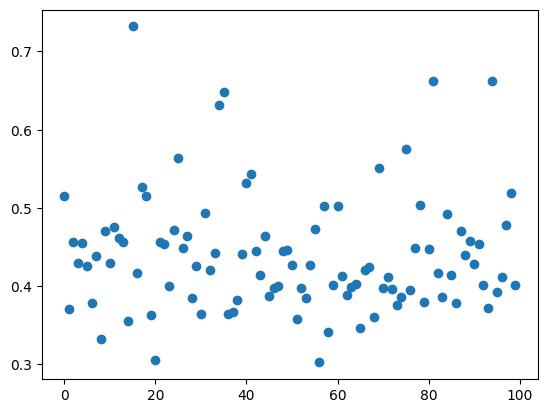

In [ ]:
import matplotlib.pyplot as plt
plt.scatter([i for i in range(len(wer))],wer)